In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

In [4]:
mnist_tanh = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.5,), (0.5,)),
             ])

# Задание 1. Сделать условный GAN — класс подается на вход Генератору и Дискриминатору.

In [5]:
with torch.cuda.device(0):
    lr = 0.0001
    prior_size = 100
    train_epoch = 1000
    batch_size = 250
    num_classes = 10
    
    train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
    
    _, fixed_loader, _ = mnist(batch_size=50, valid=10000, transform=mnist_tanh)
    fixed_data, labels = next(iter(fixed_loader))
    
    fixed_z = torch.randn((50, 100))
    fixed_y = torch.eye(10)[labels]
    batch_zeros = torch.zeros((batch_size, 1))
    batch_ones = torch.ones((batch_size, 1))

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn)
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [7]:
with torch.cuda.device(0):
    G = FullyConnected([prior_size + num_classes, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
    D = FullyConnected([28*28 + num_classes, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

    G_optimizer = optim.Adam(G.parameters(), lr=lr)
    D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [8]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [9]:
def train(epoch, G, D, log=None):
    with torch.cuda.device(0):
        train_size = len(train_loader.sampler)
        for batch_idx, (data, labels) in enumerate(train_loader):
            # train D
            y_oh = torch.eye(10)[labels]
            D.zero_grad()
            G.zero_grad()
            z = torch.randn((batch_size, prior_size))
            
            fake_pred = D(torch.cat((G(torch.cat((z, y_oh), 1)), y_oh), 1))
            data = data.view(-1, 28*28)
            true_pred = D(torch.cat((data, y_oh), 1))

            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)

            D_loss = 0.5*(fake_loss + true_loss)

            D_loss.backward()
            D_optimizer.step()

            # train G
            D.zero_grad()
            G.zero_grad()
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(torch.cat((G(torch.cat((z, y_oh), 1)), y_oh), 1))
            G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)

            G_loss.backward()

            G_optimizer.step()

            if batch_idx % 100 == 0:
                line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                    epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
                losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
                print(line + losses)

        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            log['G'].append(G_loss.item())
            log['D'].append(D_loss.item())

In [10]:
def test(G, D, loader, epoch, log=None):
    with torch.cuda.device(0):
        test_size = len(loader)
        G_loss = 0.
        D_loss = 0.
        test_loss = {'G': 0., 'D': 0.}
        with torch.no_grad():
            for data, labels in loader:
                z = torch.randn((batch_size, prior_size))
                y_oh = torch.eye(10)[labels]
                
                fake_pred = D(torch.cat((G(torch.cat((z, y_oh), 1)), y_oh), 1))
                data = data.view(-1, 28*28)
                true_pred = D(torch.cat((data, y_oh), 1))

                fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
                true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()

                D_loss += 0.5*(fake_loss + true_loss)
                G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()

        G_loss /= test_size
        D_loss /= test_size

        fixed_gen = G(torch.cat((fixed_z, fixed_y), 1)).data.numpy().reshape(50, 1, 28, 28)
        plot_mnist(fixed_data, (5, 10))
        plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
        report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
        print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.7049, D: 0.6910
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 1.0781, D: 0.3300
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.3396, D: 0.6227


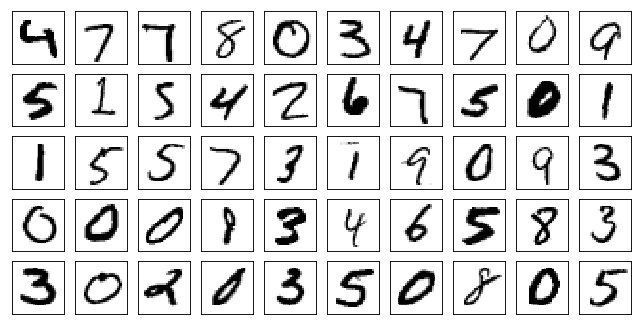

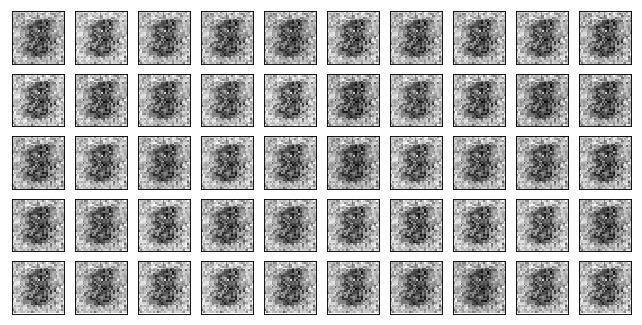

Test losses. G: 0.4740, D: 0.6523
Train Epoch: 2 [0/50000 (0%)]	Losses G: 1.1721, D: 0.7482
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 1.8708, D: 0.3592
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 1.6064, D: 1.1321


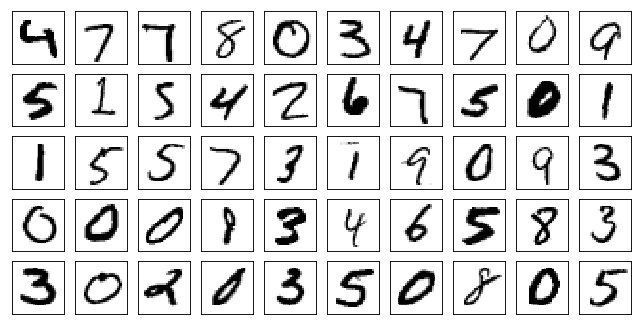

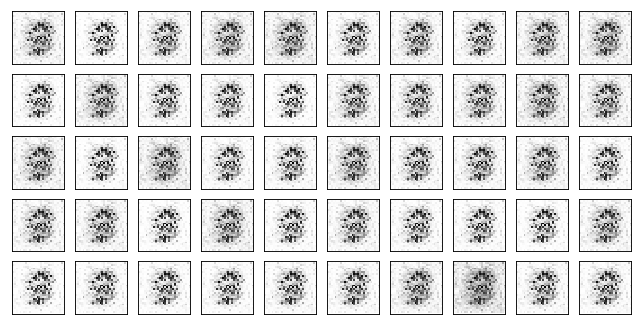

Test losses. G: 0.4768, D: 1.1684
Train Epoch: 3 [0/50000 (0%)]	Losses G: 1.2495, D: 1.2294
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 0.8927, D: 1.1748
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 1.6878, D: 0.5979


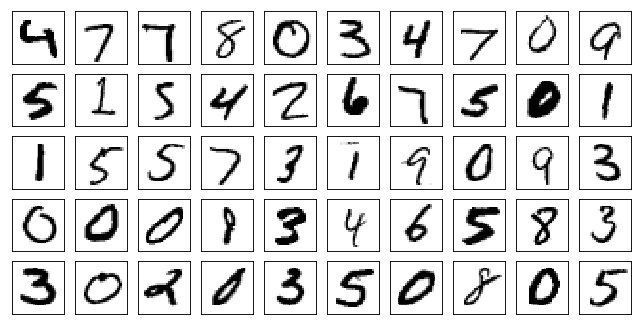

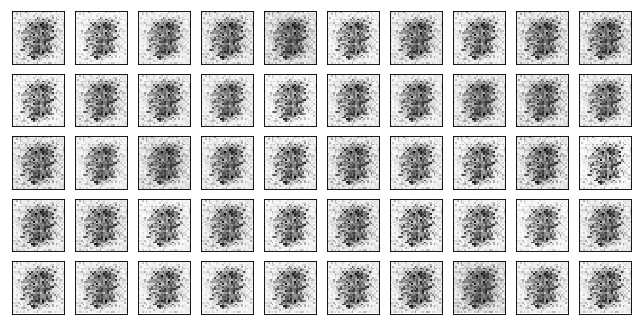

Test losses. G: 0.7170, D: 0.5975
Train Epoch: 4 [0/50000 (0%)]	Losses G: 1.5371, D: 0.6259
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 1.8994, D: 0.3538
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 2.9517, D: 0.2083


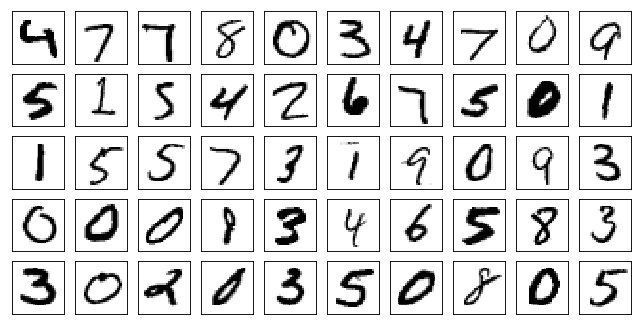

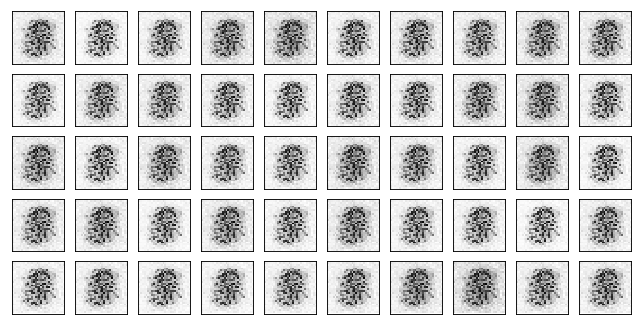

Test losses. G: 2.2820, D: 0.1350
Train Epoch: 5 [0/50000 (0%)]	Losses G: 3.0179, D: 0.2208
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 1.0667, D: 0.7253
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 2.5711, D: 0.1322


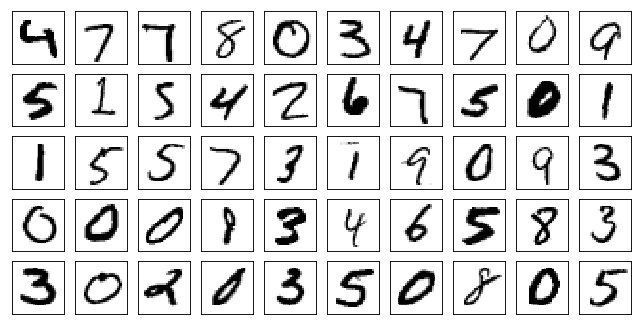

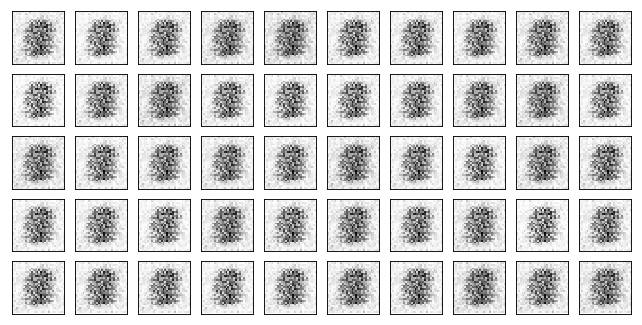

Test losses. G: 2.2088, D: 0.1041
Train Epoch: 6 [0/50000 (0%)]	Losses G: 2.5246, D: 0.1239
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 1.7665, D: 0.5126
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 2.0652, D: 0.2135


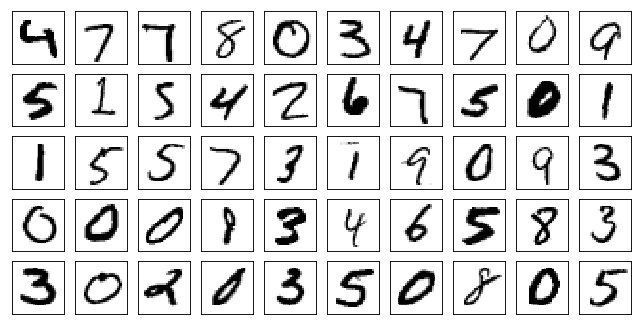

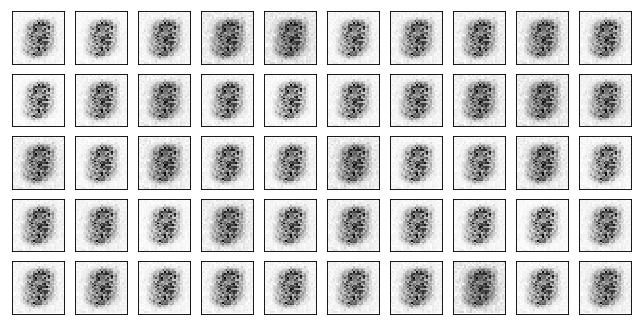

Test losses. G: 1.8899, D: 0.1857
Train Epoch: 7 [0/50000 (0%)]	Losses G: 1.9530, D: 0.2853
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 3.0215, D: 0.1566
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 4.1242, D: 0.0469


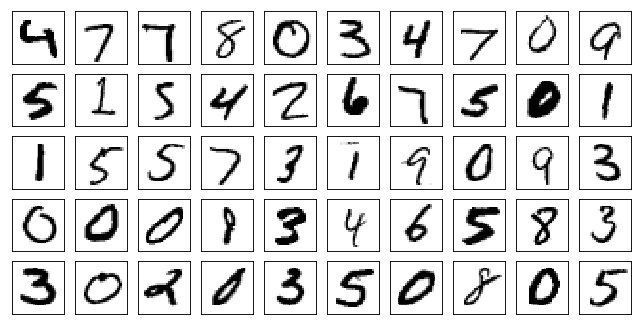

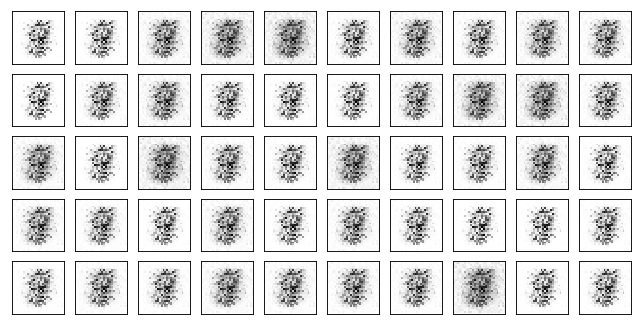

Test losses. G: 3.6833, D: 0.0191
Train Epoch: 8 [0/50000 (0%)]	Losses G: 4.0621, D: 0.0389
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 3.2152, D: 0.1197
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 4.4664, D: 0.1157


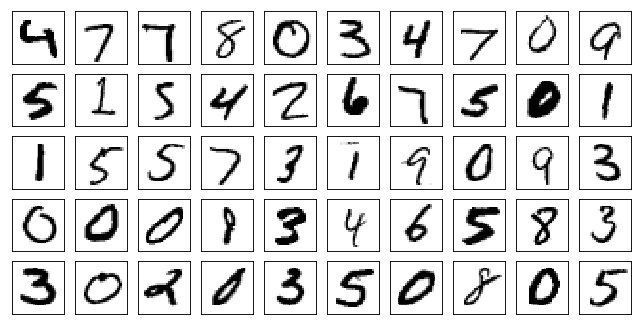

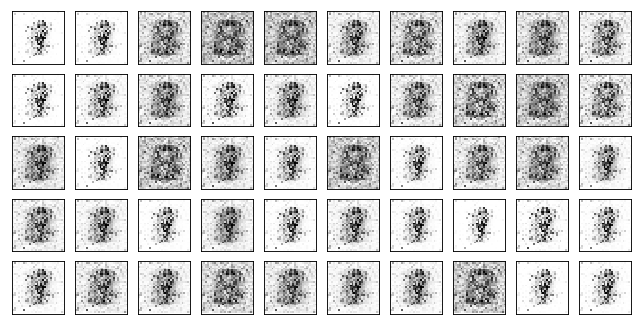

Test losses. G: 4.0430, D: 0.0707
Train Epoch: 9 [0/50000 (0%)]	Losses G: 4.4793, D: 0.0961
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 3.3355, D: 0.1249
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 4.0549, D: 0.1268


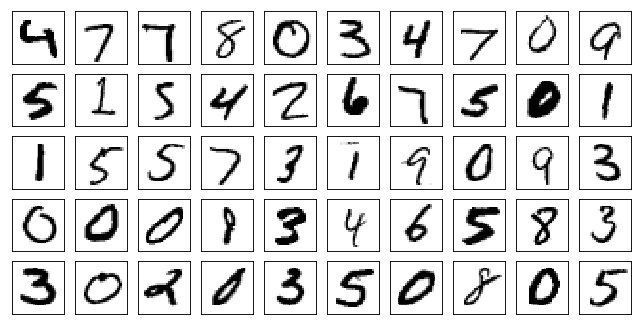

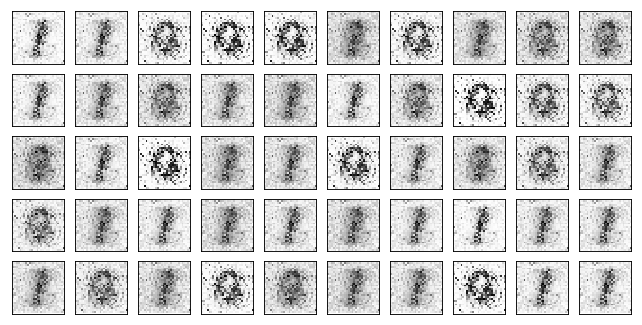

Test losses. G: 3.5734, D: 0.0558
Train Epoch: 10 [0/50000 (0%)]	Losses G: 3.9771, D: 0.1118
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 4.4288, D: 0.1787
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 4.4120, D: 0.0700


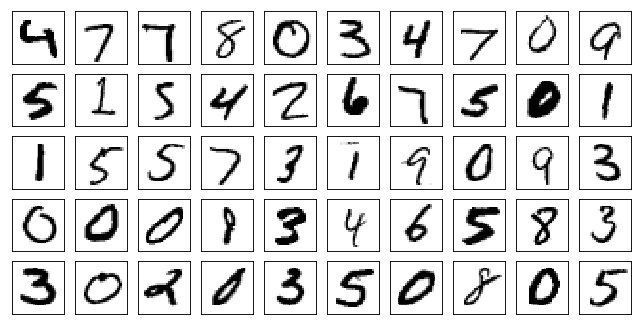

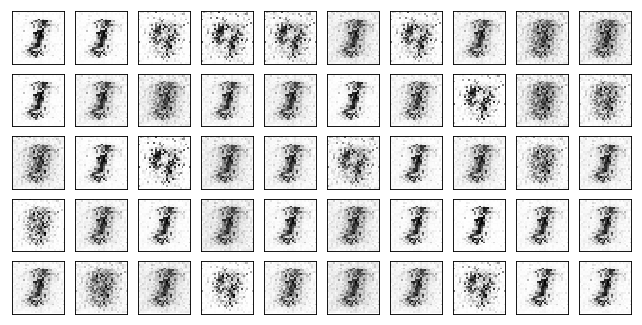

Test losses. G: 4.1559, D: 0.0193
Train Epoch: 11 [0/50000 (0%)]	Losses G: 4.1833, D: 0.0657
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 4.9506, D: 0.1197
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 5.0385, D: 0.0859


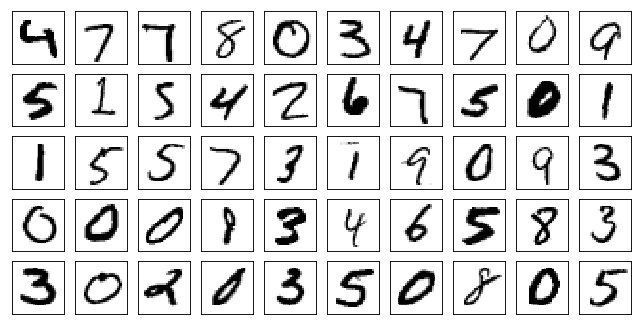

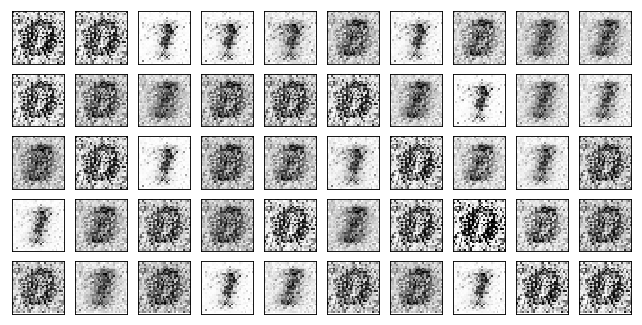

Test losses. G: 4.0125, D: 0.0272
Train Epoch: 12 [0/50000 (0%)]	Losses G: 4.8275, D: 0.1116
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 5.6891, D: 0.0701
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 4.6911, D: 0.0969


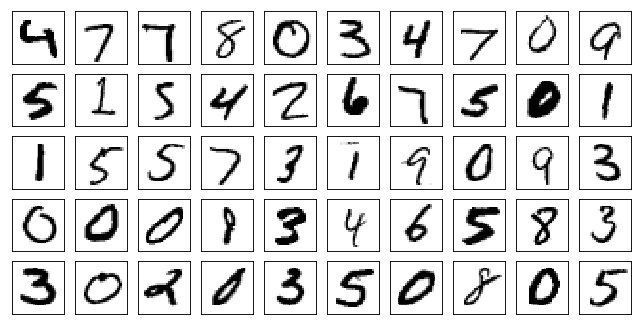

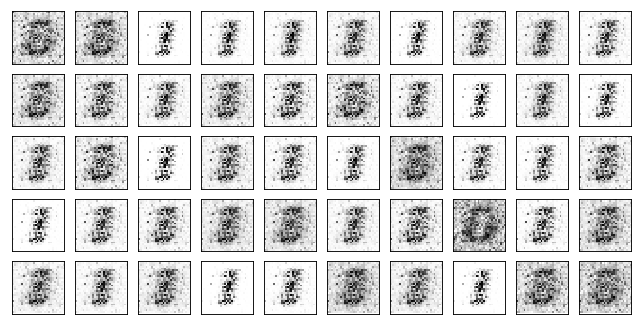

Test losses. G: 4.0378, D: 0.0212
Train Epoch: 13 [0/50000 (0%)]	Losses G: 4.5823, D: 0.0540
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 5.1871, D: 0.0421
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 4.7797, D: 0.0742


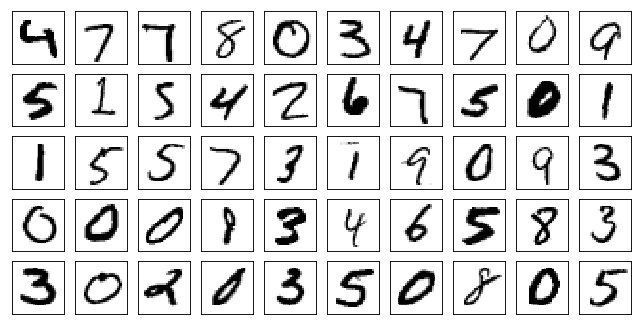

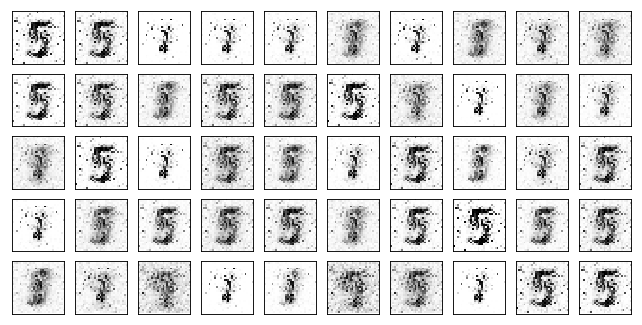

Test losses. G: 4.3249, D: 0.0247
Train Epoch: 14 [0/50000 (0%)]	Losses G: 4.7685, D: 0.0719
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 4.7860, D: 0.0426
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 5.4733, D: 0.0860


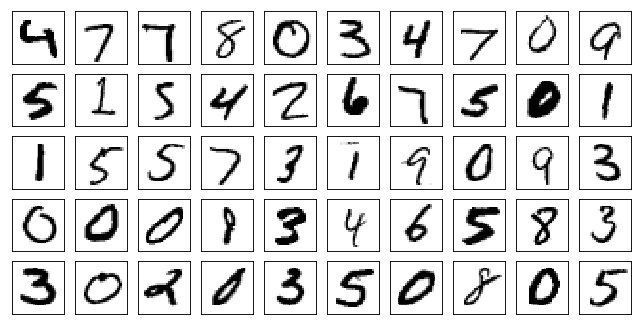

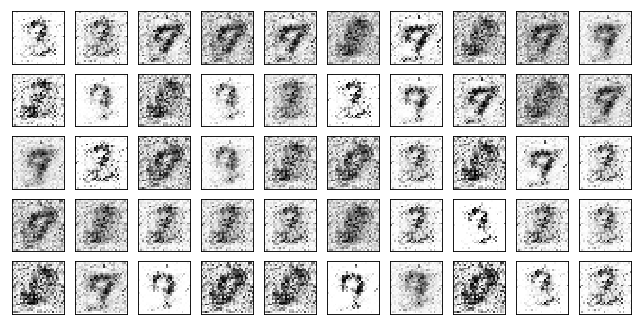

Test losses. G: 3.9454, D: 0.0228
Train Epoch: 15 [0/50000 (0%)]	Losses G: 5.6527, D: 0.1039
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 5.3555, D: 0.0877
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 6.3876, D: 0.0554


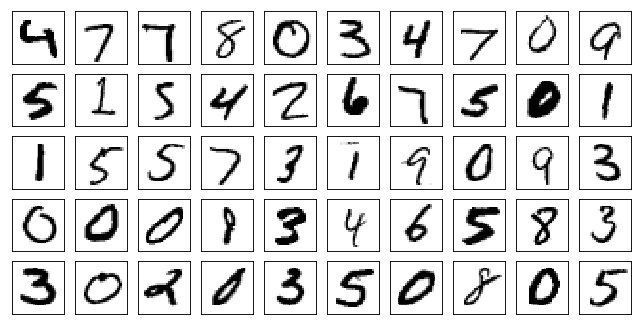

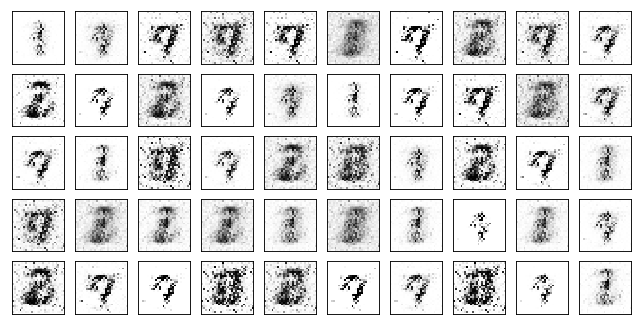

Test losses. G: 5.5834, D: 0.0203
Train Epoch: 16 [0/50000 (0%)]	Losses G: 6.6107, D: 0.0473
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 5.6642, D: 0.0933
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 3.8871, D: 0.1237


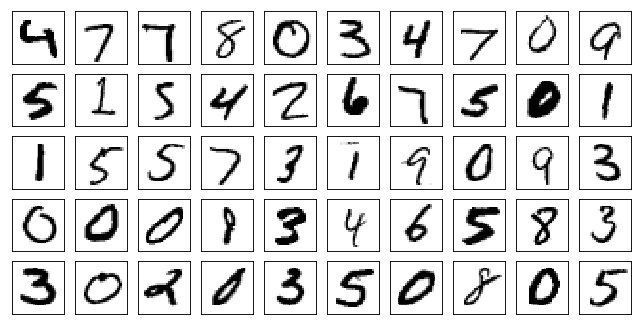

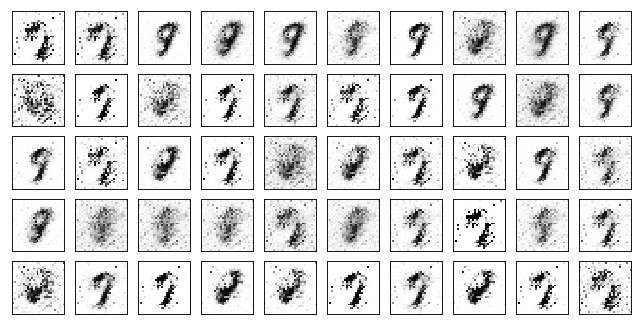

Test losses. G: 3.1240, D: 0.0525
Train Epoch: 17 [0/50000 (0%)]	Losses G: 4.3794, D: 0.1151
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 5.2819, D: 0.0821
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 4.3314, D: 0.1131


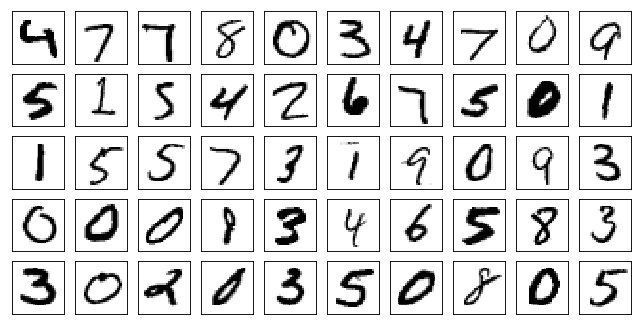

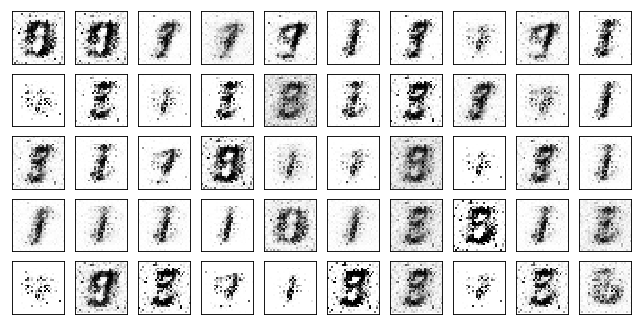

Test losses. G: 3.6026, D: 0.0467
Train Epoch: 18 [0/50000 (0%)]	Losses G: 4.6006, D: 0.1218
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 4.9474, D: 0.0675
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 4.1867, D: 0.1221


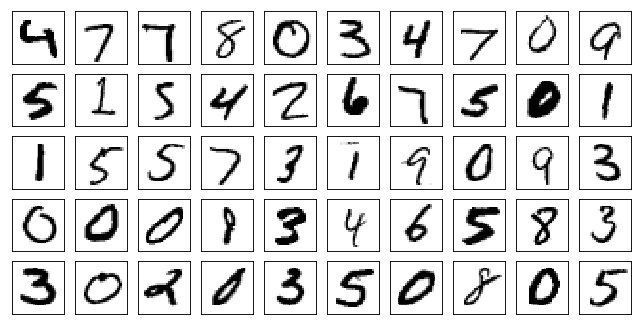

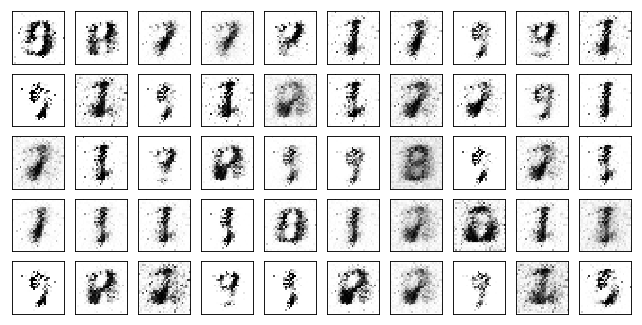

Test losses. G: 3.5440, D: 0.0505
Train Epoch: 19 [0/50000 (0%)]	Losses G: 4.2928, D: 0.0990
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 6.1580, D: 0.0439
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 5.7609, D: 0.0705


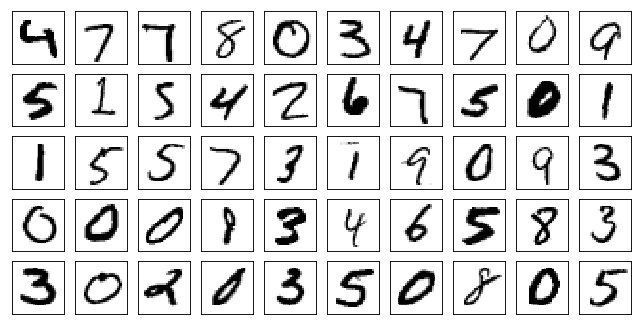

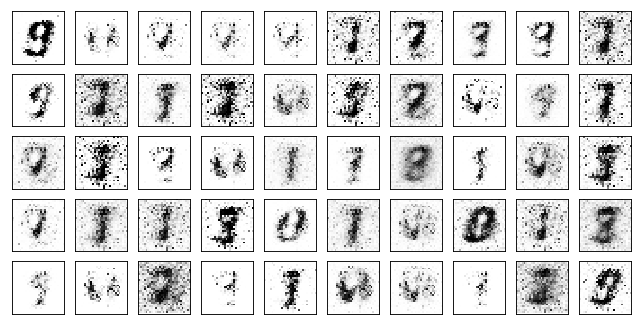

Test losses. G: 5.0822, D: 0.0227
Train Epoch: 20 [0/50000 (0%)]	Losses G: 5.4651, D: 0.0554
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 5.8525, D: 0.1051
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 5.2698, D: 0.0675


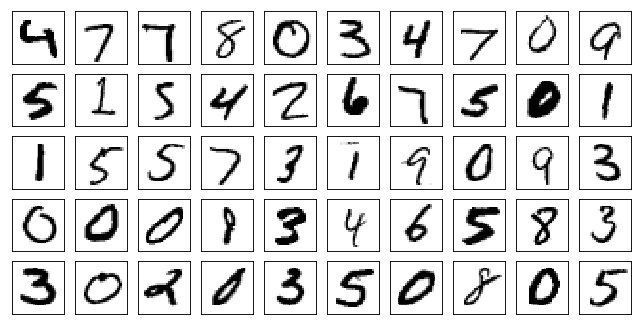

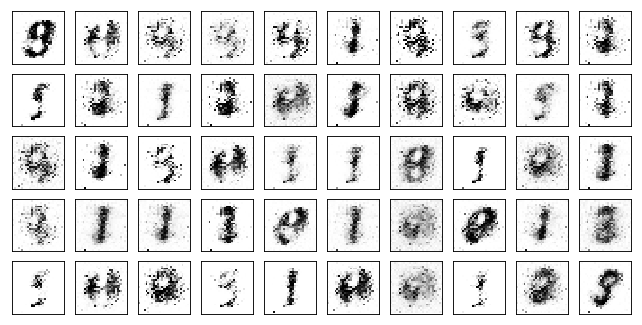

Test losses. G: 4.6895, D: 0.0227
Train Epoch: 21 [0/50000 (0%)]	Losses G: 5.3163, D: 0.1000
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 5.9043, D: 0.0871
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 7.2407, D: 0.0500


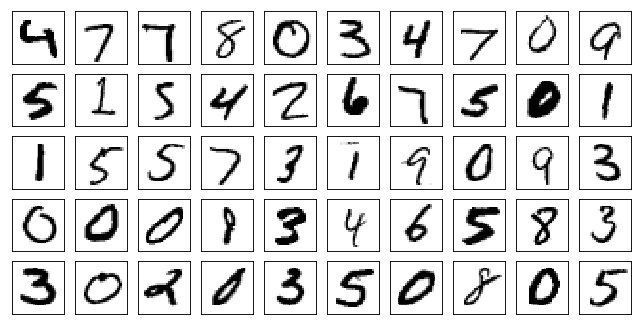

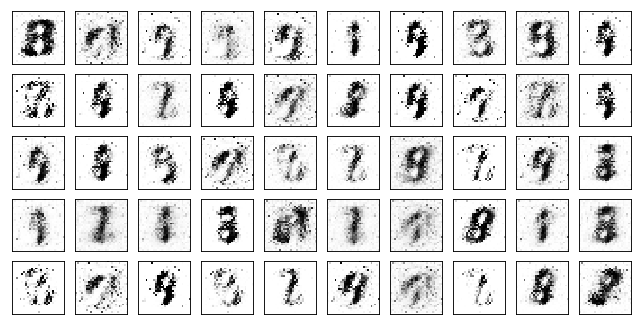

Test losses. G: 6.0964, D: 0.0335
Train Epoch: 22 [0/50000 (0%)]	Losses G: 6.7878, D: 0.1027
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 5.1836, D: 0.0691
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 5.4040, D: 0.0885


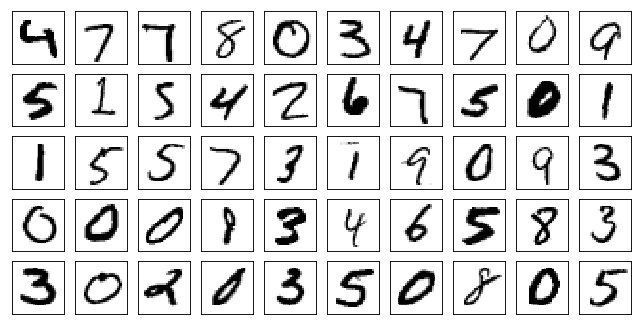

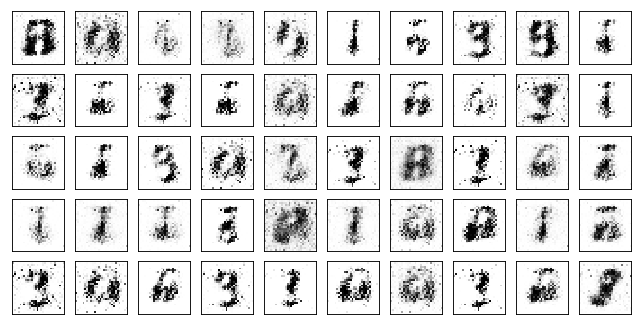

Test losses. G: 4.1269, D: 0.0341
Train Epoch: 23 [0/50000 (0%)]	Losses G: 5.9108, D: 0.0819
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 5.9381, D: 0.0736
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 4.6057, D: 0.0594


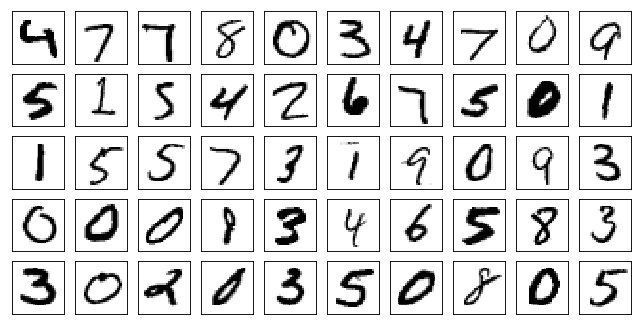

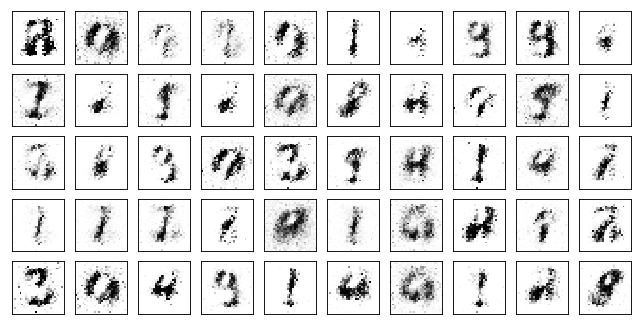

Test losses. G: 4.1014, D: 0.0318
Train Epoch: 24 [0/50000 (0%)]	Losses G: 4.6107, D: 0.0782
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 4.7990, D: 0.1316
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 4.8143, D: 0.0845


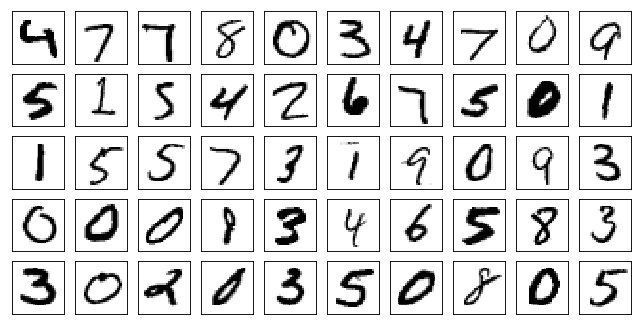

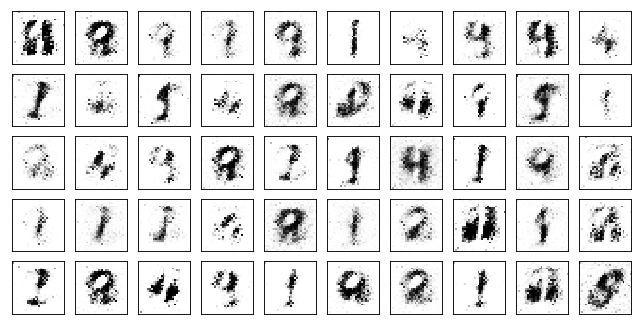

Test losses. G: 4.5200, D: 0.0274
Train Epoch: 25 [0/50000 (0%)]	Losses G: 4.6406, D: 0.0963
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 5.5402, D: 0.1036
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 4.7735, D: 0.1512


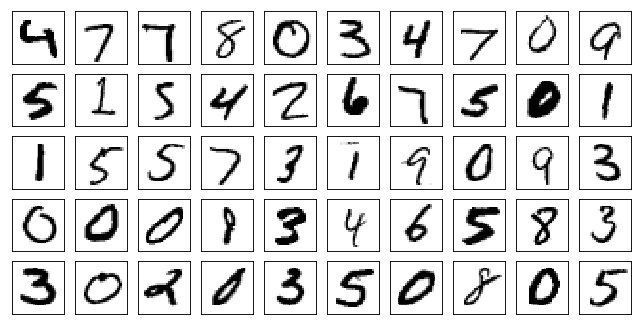

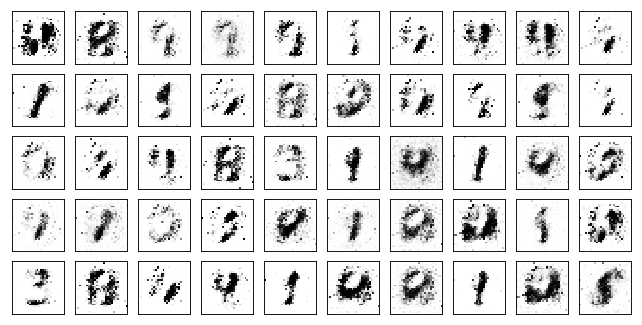

Test losses. G: 4.1339, D: 0.0416
Train Epoch: 26 [0/50000 (0%)]	Losses G: 4.4934, D: 0.1371
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 5.4048, D: 0.1121
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 5.2724, D: 0.1583


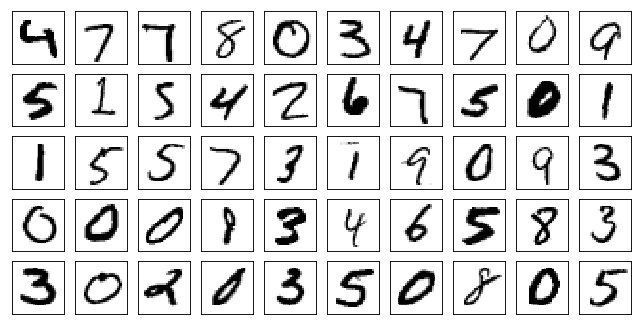

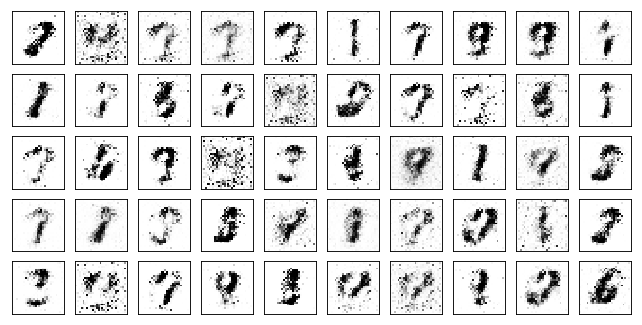

Test losses. G: 4.3074, D: 0.0620
Train Epoch: 27 [0/50000 (0%)]	Losses G: 4.6320, D: 0.1273
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 5.3721, D: 0.1031
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 4.0542, D: 0.1035


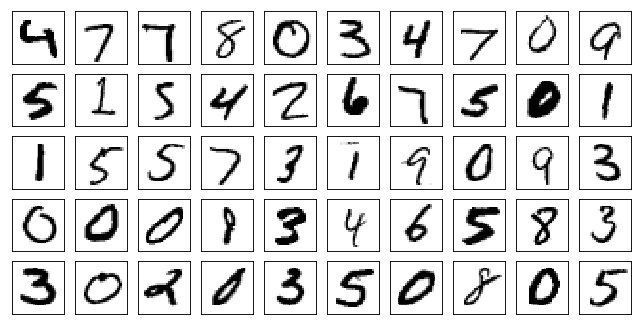

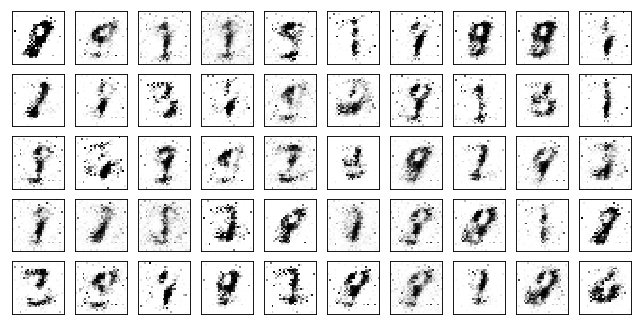

Test losses. G: 3.4833, D: 0.0494
Train Epoch: 28 [0/50000 (0%)]	Losses G: 5.3223, D: 0.1375
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 4.7786, D: 0.0884
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 5.5857, D: 0.1230


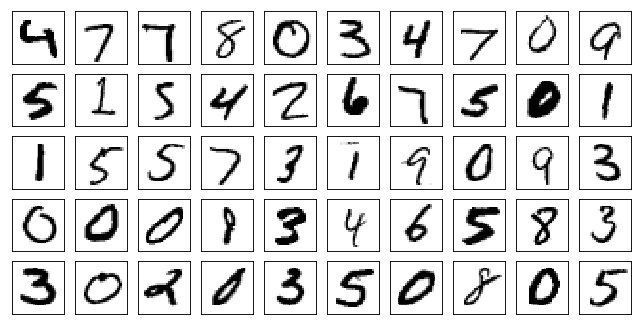

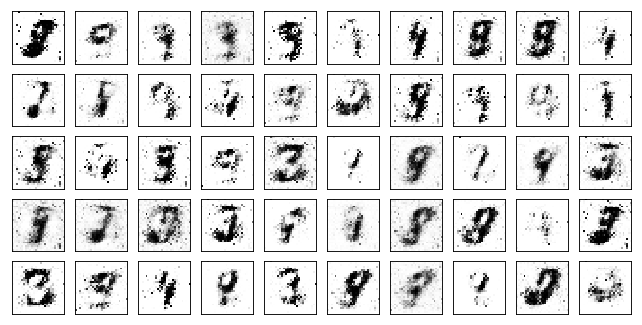

Test losses. G: 4.7541, D: 0.0280
Train Epoch: 29 [0/50000 (0%)]	Losses G: 4.6548, D: 0.0808
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 5.7363, D: 0.0973
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 5.8200, D: 0.1087


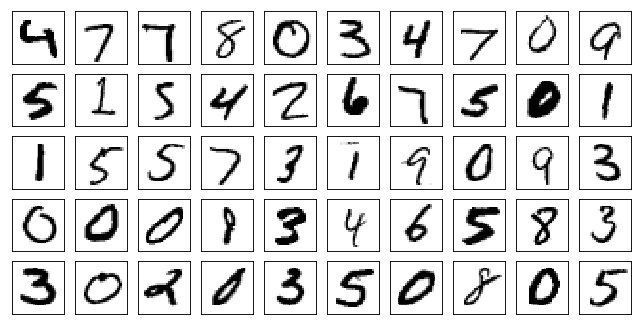

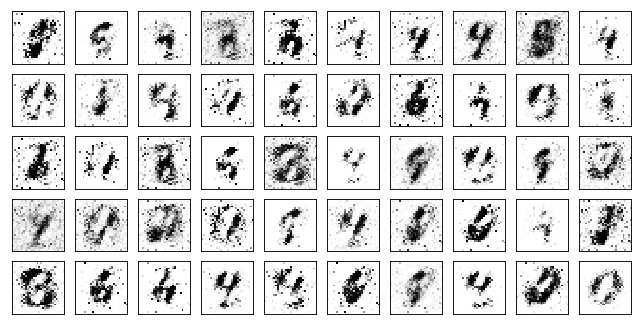

Test losses. G: 5.1198, D: 0.0497
Train Epoch: 30 [0/50000 (0%)]	Losses G: 5.2747, D: 0.1466
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 5.5202, D: 0.1155
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 4.4631, D: 0.0921


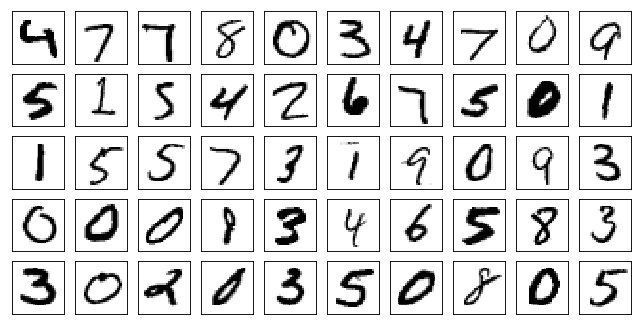

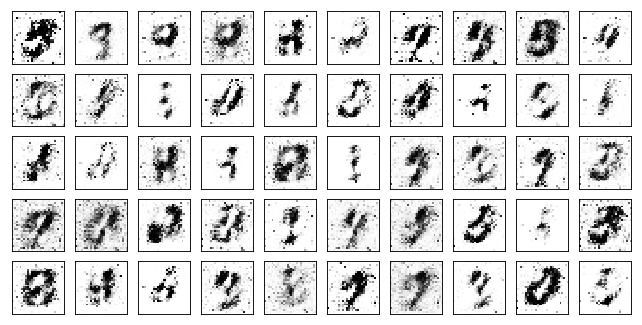

Test losses. G: 3.7530, D: 0.0492


In [11]:
with torch.cuda.device(0):
    for epoch in range(1, 31):
        G.train()
        D.train()
        train(epoch, G, D, train_log)
        G.eval()
        D.eval()
        test(G, D, valid_loader, epoch, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 4.0040, D: 0.1051
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 4.1212, D: 0.1403
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 3.9417, D: 0.1695


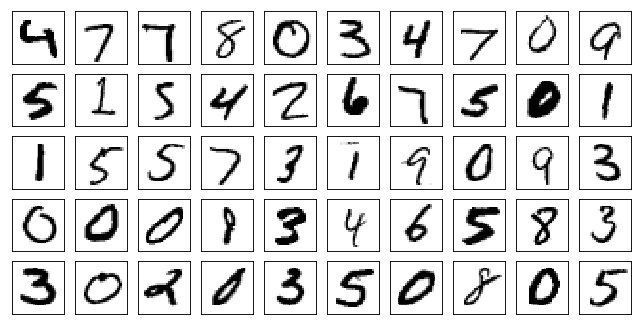

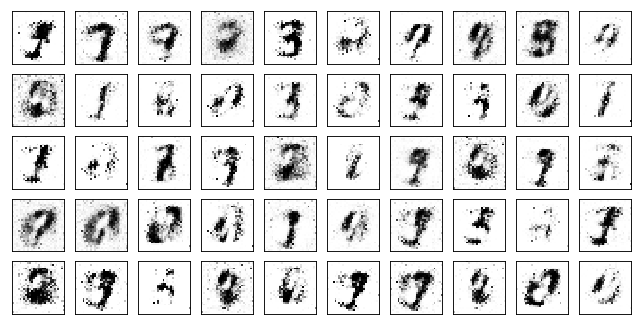

Test losses. G: 3.2388, D: 0.0782
Train Epoch: 2 [0/50000 (0%)]	Losses G: 4.4118, D: 0.1768
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 4.4727, D: 0.1528
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 4.6976, D: 0.1376


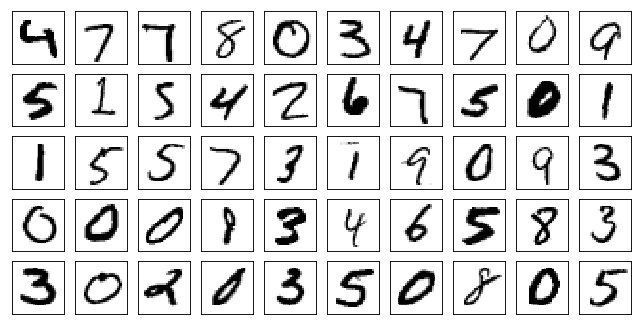

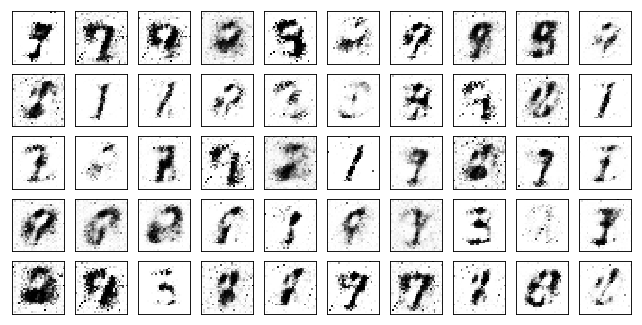

Test losses. G: 4.1493, D: 0.0493
Train Epoch: 3 [0/50000 (0%)]	Losses G: 4.5650, D: 0.1057
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 4.4701, D: 0.1361
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 4.2044, D: 0.1783


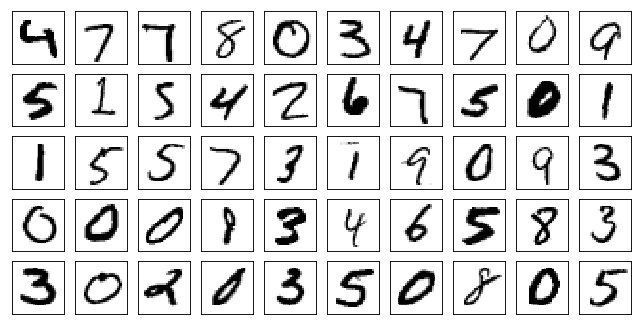

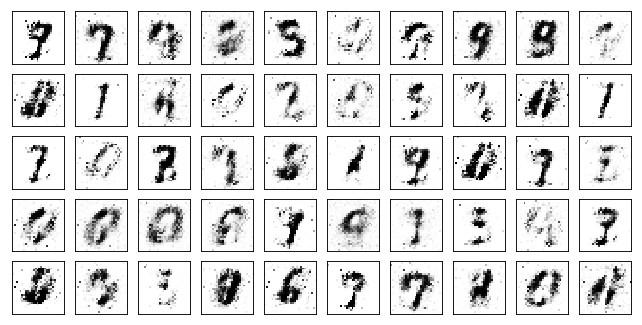

Test losses. G: 3.7450, D: 0.0718
Train Epoch: 4 [0/50000 (0%)]	Losses G: 5.0191, D: 0.1693
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 3.0791, D: 0.1615
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 3.8717, D: 0.1832


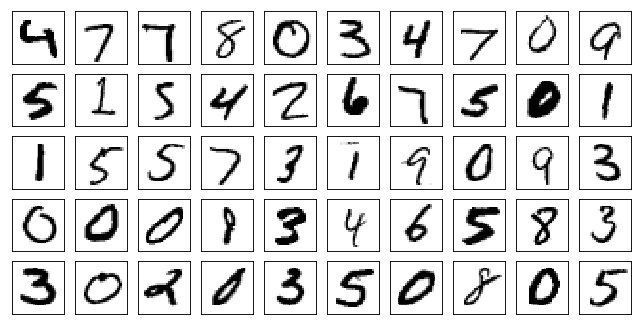

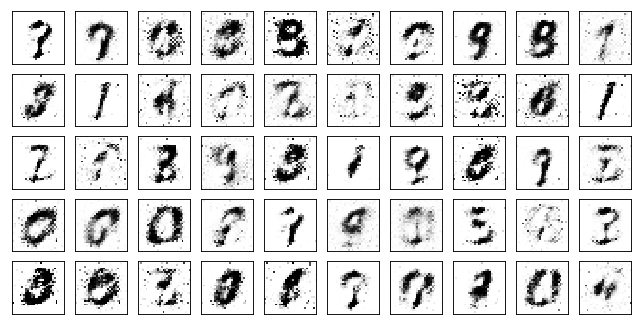

Test losses. G: 3.1653, D: 0.0829
Train Epoch: 5 [0/50000 (0%)]	Losses G: 4.0361, D: 0.1559
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 3.1184, D: 0.2005
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 4.0658, D: 0.1723


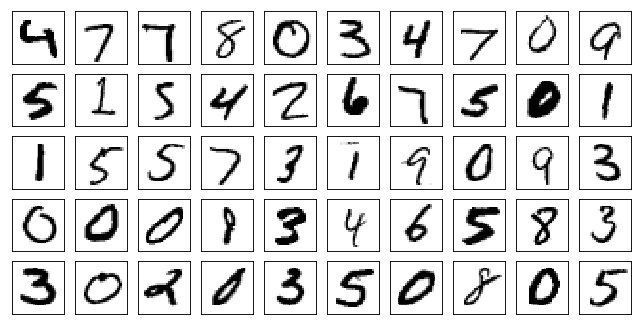

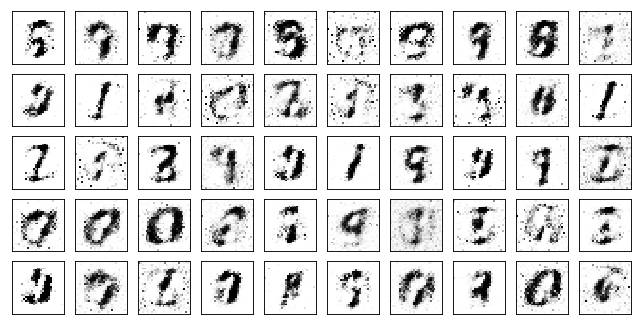

Test losses. G: 3.3984, D: 0.0669
Train Epoch: 6 [0/50000 (0%)]	Losses G: 3.9157, D: 0.1597
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 4.4549, D: 0.1249
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 4.5865, D: 0.1823


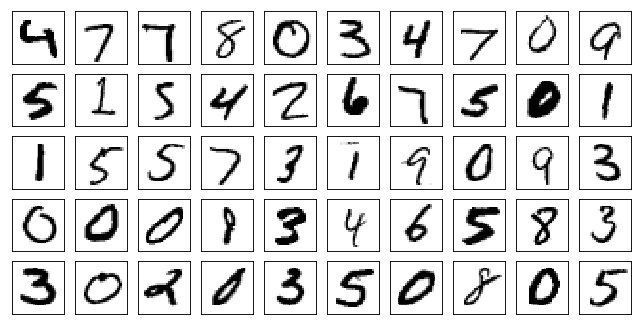

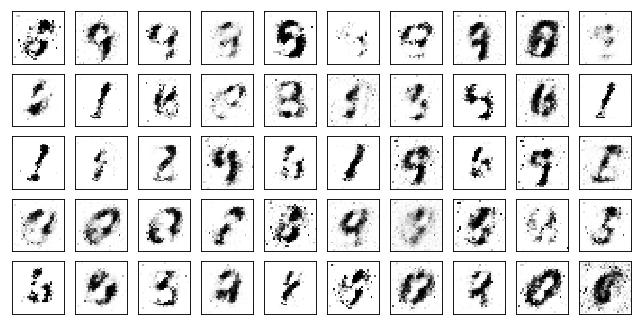

Test losses. G: 3.8735, D: 0.0663
Train Epoch: 7 [0/50000 (0%)]	Losses G: 4.8604, D: 0.2017
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 4.4478, D: 0.0930
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 4.3120, D: 0.1263


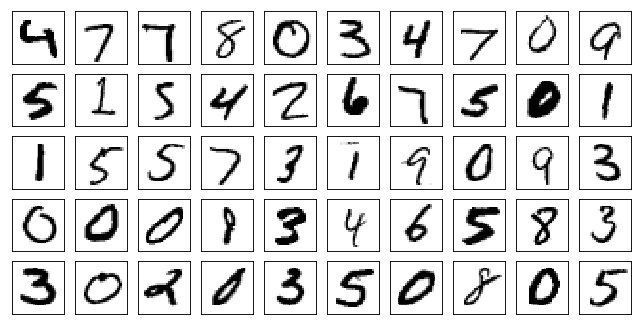

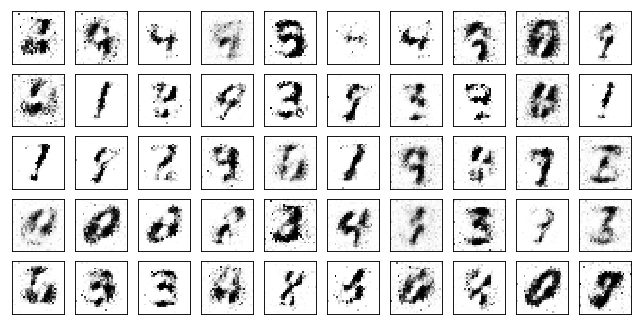

Test losses. G: 3.9693, D: 0.0474
Train Epoch: 8 [0/50000 (0%)]	Losses G: 4.5523, D: 0.0967
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 5.1713, D: 0.1476
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 3.6952, D: 0.1997


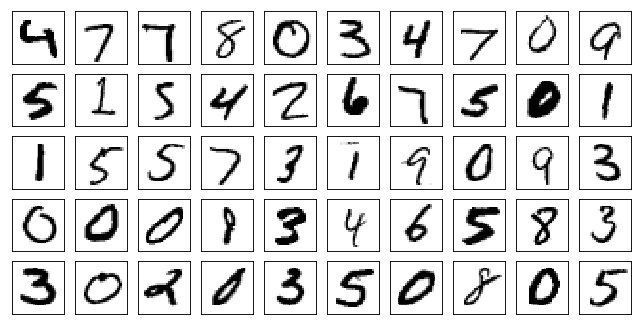

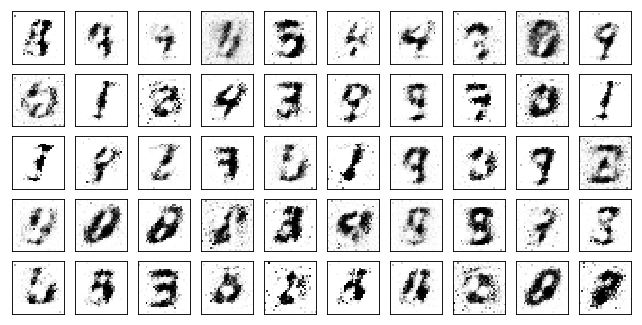

Test losses. G: 3.2313, D: 0.0883
Train Epoch: 9 [0/50000 (0%)]	Losses G: 4.4626, D: 0.1754
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 4.6303, D: 0.1591
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.2126, D: 0.1813


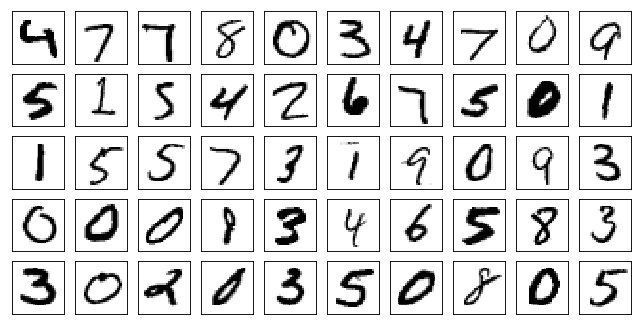

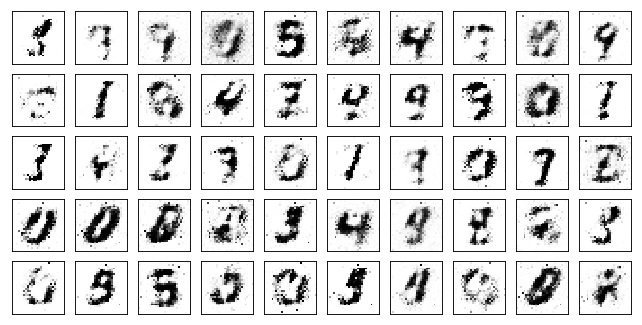

Test losses. G: 2.8303, D: 0.1047
Train Epoch: 10 [0/50000 (0%)]	Losses G: 3.2543, D: 0.1838
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 4.0163, D: 0.1698
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 3.7054, D: 0.1814


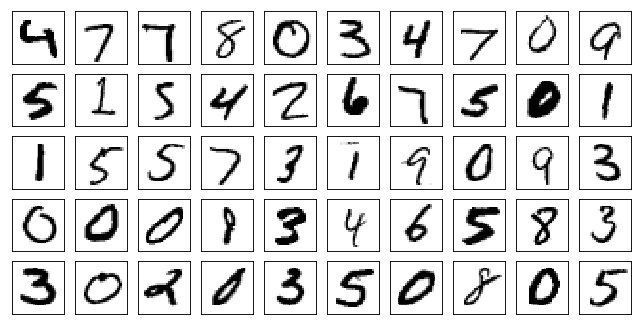

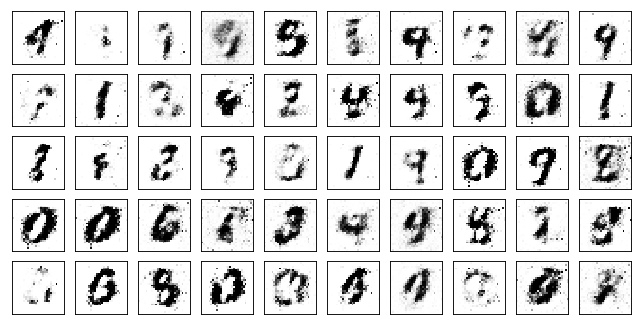

Test losses. G: 3.3628, D: 0.0854
Train Epoch: 11 [0/50000 (0%)]	Losses G: 4.0680, D: 0.1933
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 4.7178, D: 0.1813
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 3.4047, D: 0.2738


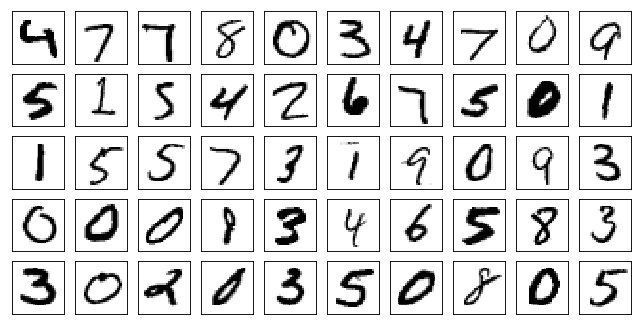

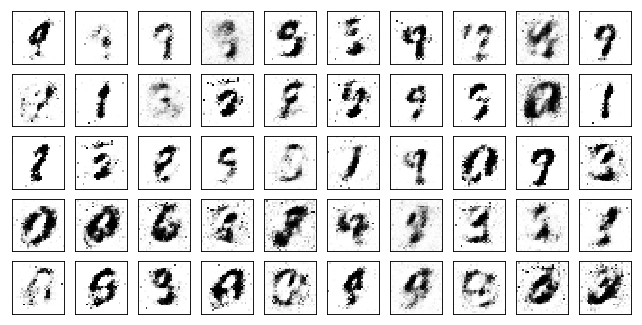

Test losses. G: 2.9851, D: 0.1385
Train Epoch: 12 [0/50000 (0%)]	Losses G: 2.9081, D: 0.1967
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 3.6491, D: 0.1590
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 3.1097, D: 0.1932


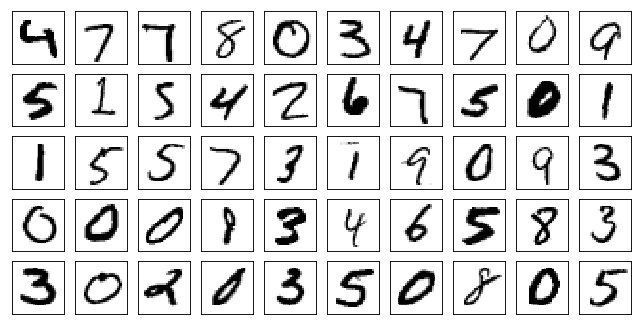

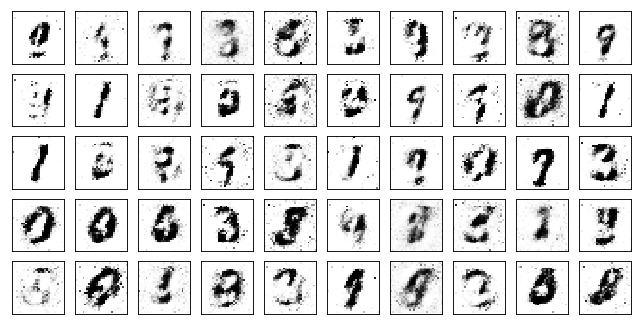

Test losses. G: 2.8983, D: 0.1149
Train Epoch: 13 [0/50000 (0%)]	Losses G: 3.7704, D: 0.2134
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 2.9955, D: 0.1788
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 2.5809, D: 0.2562


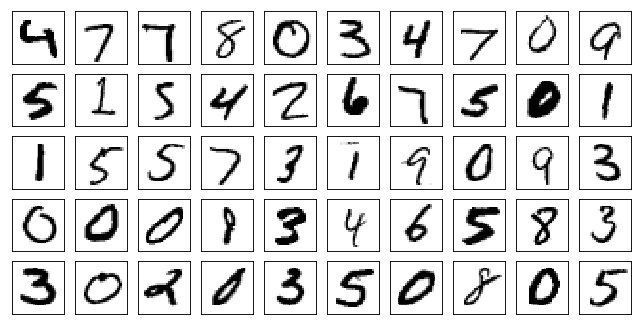

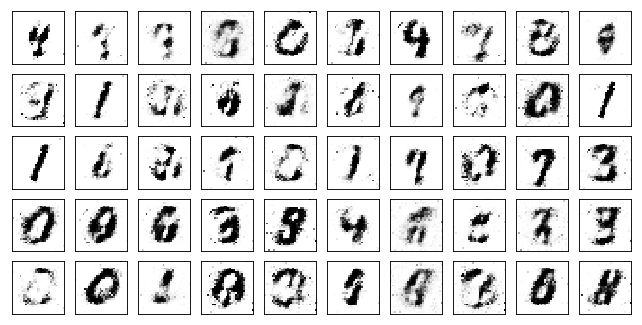

Test losses. G: 2.3350, D: 0.1608
Train Epoch: 14 [0/50000 (0%)]	Losses G: 2.7713, D: 0.2154
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 4.2447, D: 0.1111
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 3.6138, D: 0.1835


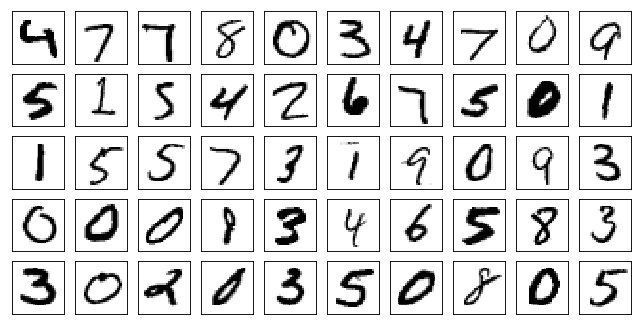

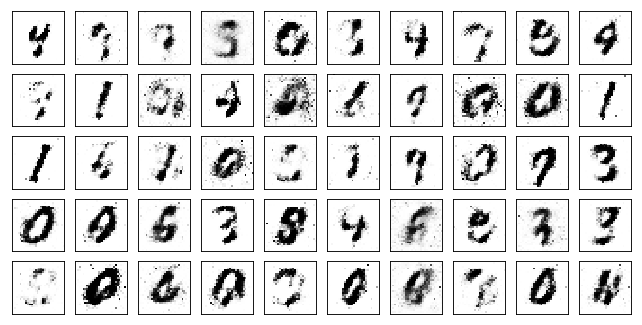

Test losses. G: 3.2055, D: 0.1212
Train Epoch: 15 [0/50000 (0%)]	Losses G: 3.2210, D: 0.2472
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 4.4498, D: 0.1833
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 2.8064, D: 0.2450


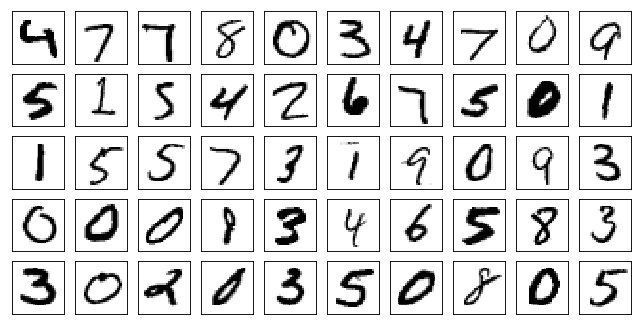

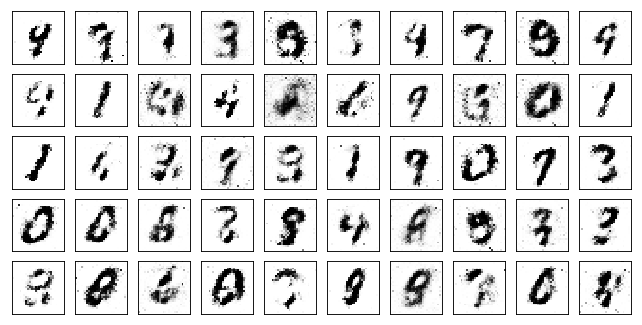

Test losses. G: 2.5463, D: 0.1275
Train Epoch: 16 [0/50000 (0%)]	Losses G: 2.2828, D: 0.2048
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 2.8518, D: 0.2752
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 2.9868, D: 0.2390


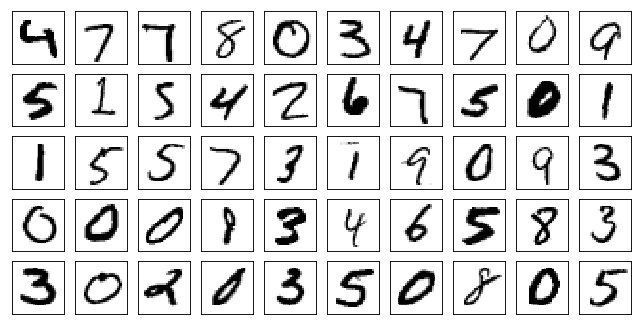

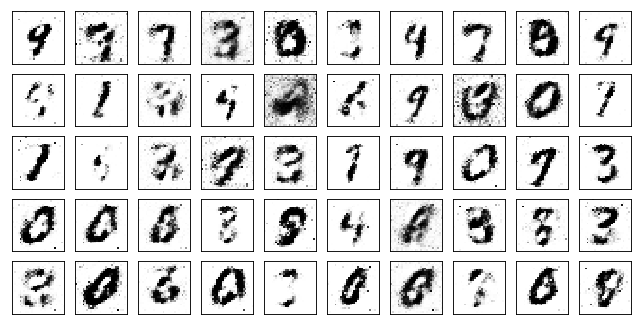

Test losses. G: 2.6836, D: 0.1484
Train Epoch: 17 [0/50000 (0%)]	Losses G: 3.5812, D: 0.2357
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 4.6261, D: 0.1830
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 2.9910, D: 0.2358


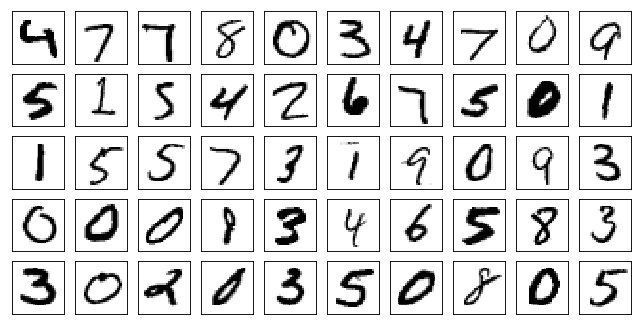

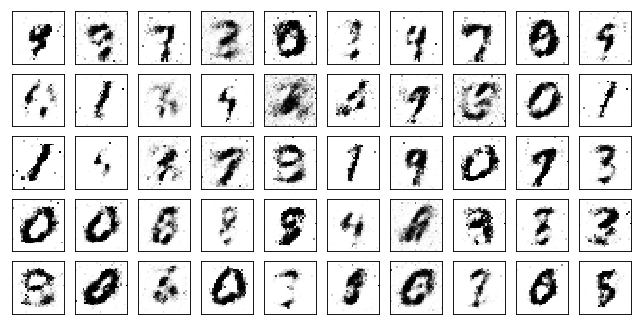

Test losses. G: 2.7139, D: 0.1513
Train Epoch: 18 [0/50000 (0%)]	Losses G: 2.6088, D: 0.2433
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 3.7636, D: 0.2189
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 2.5596, D: 0.2266


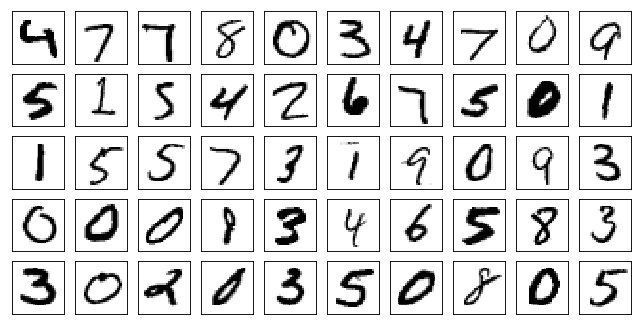

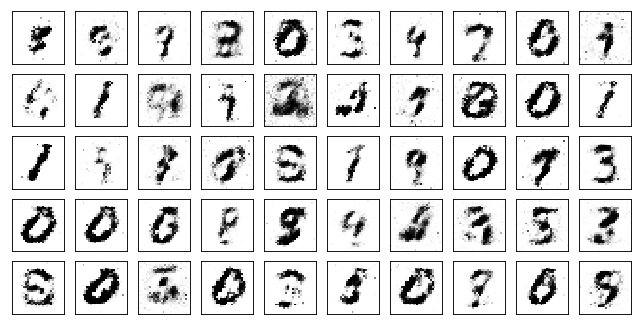

Test losses. G: 2.5375, D: 0.1618
Train Epoch: 19 [0/50000 (0%)]	Losses G: 2.7742, D: 0.2723
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 2.7833, D: 0.2523
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 3.0669, D: 0.2192


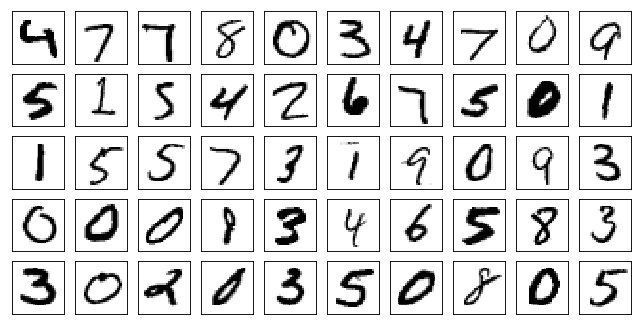

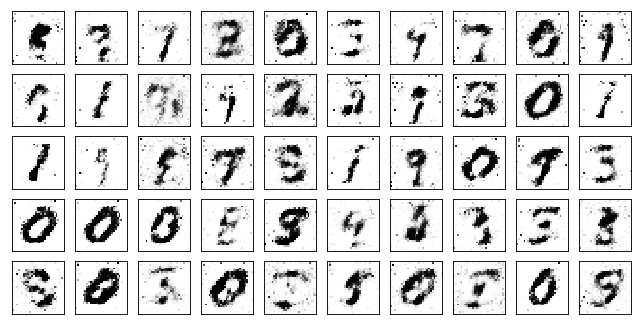

Test losses. G: 2.7764, D: 0.1285
Train Epoch: 20 [0/50000 (0%)]	Losses G: 3.2246, D: 0.1984
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 2.7686, D: 0.2476
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 2.6848, D: 0.2217


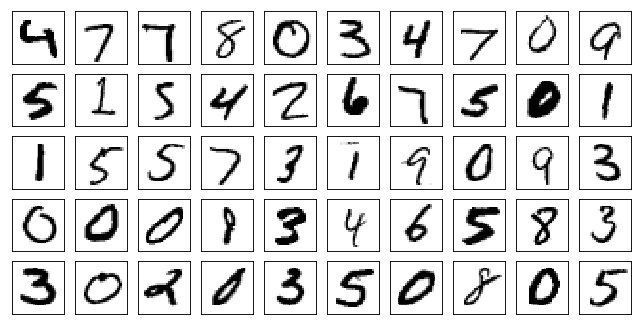

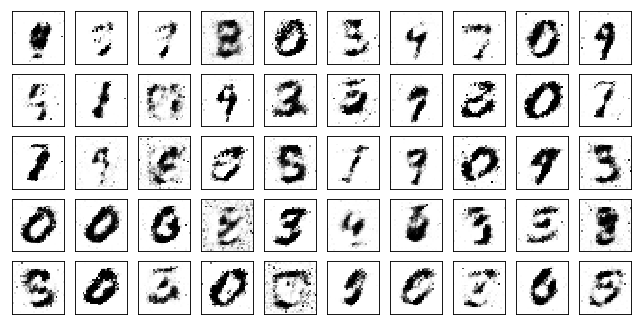

Test losses. G: 2.5321, D: 0.1415
Train Epoch: 21 [0/50000 (0%)]	Losses G: 2.9594, D: 0.2593
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 2.4071, D: 0.2140
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 2.9820, D: 0.2019


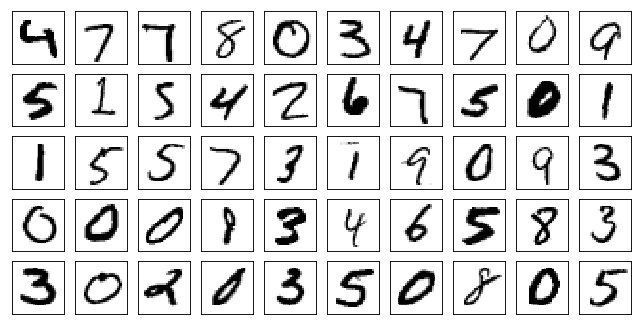

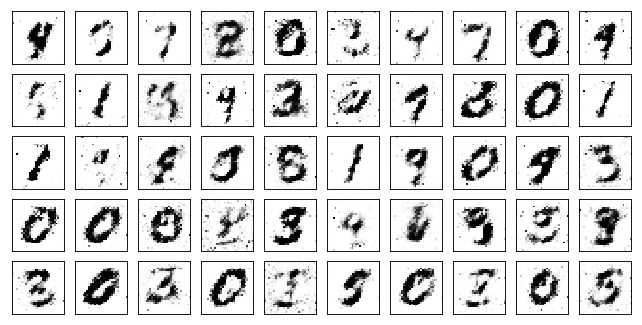

Test losses. G: 2.6873, D: 0.1410
Train Epoch: 22 [0/50000 (0%)]	Losses G: 3.3378, D: 0.2110
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 4.0815, D: 0.2472
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 3.1803, D: 0.2536


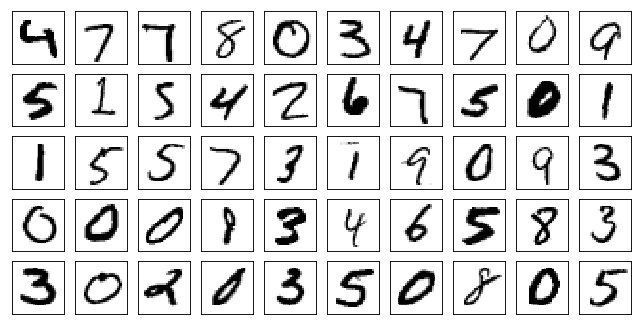

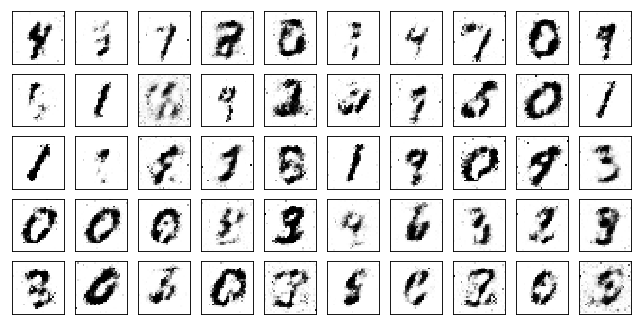

Test losses. G: 2.9833, D: 0.1437
Train Epoch: 23 [0/50000 (0%)]	Losses G: 3.0334, D: 0.2421
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 2.3367, D: 0.2545
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 2.7053, D: 0.2881


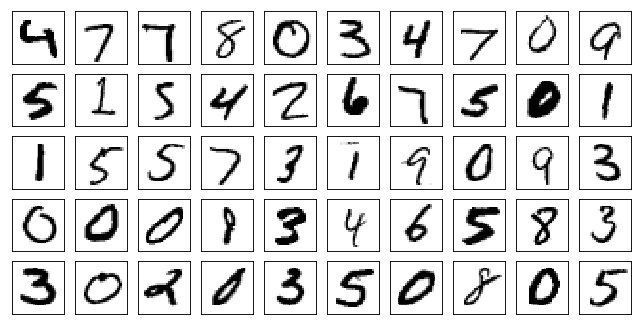

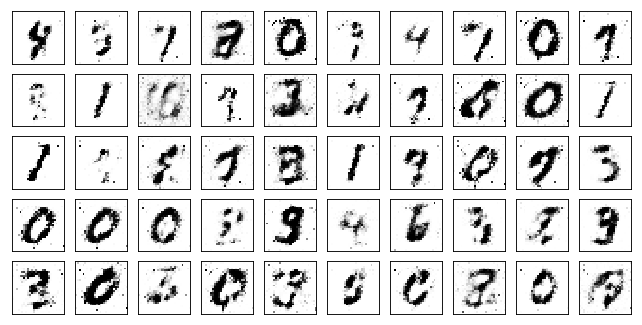

Test losses. G: 2.6276, D: 0.1259
Train Epoch: 24 [0/50000 (0%)]	Losses G: 3.5977, D: 0.1786
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 3.1308, D: 0.2279
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 2.6862, D: 0.3381


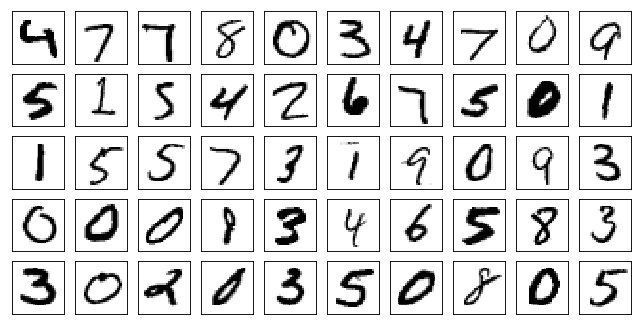

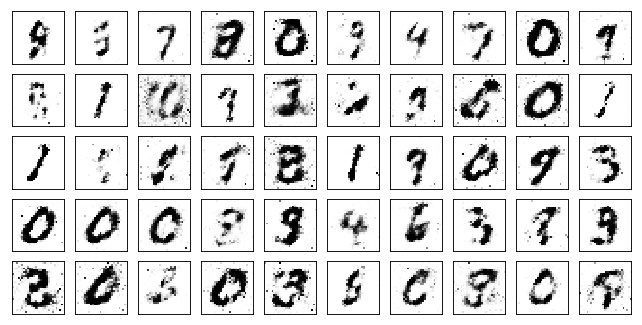

Test losses. G: 2.3999, D: 0.1896
Train Epoch: 25 [0/50000 (0%)]	Losses G: 2.0113, D: 0.3164
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 2.4212, D: 0.2798
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 2.6750, D: 0.2483


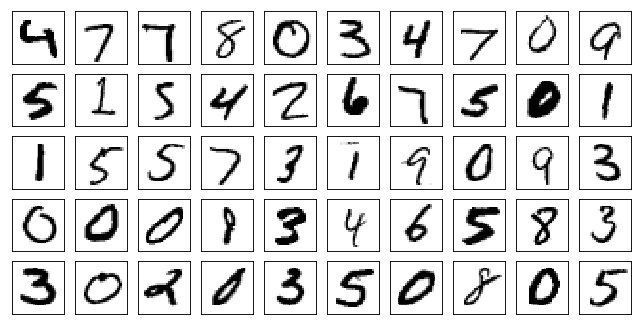

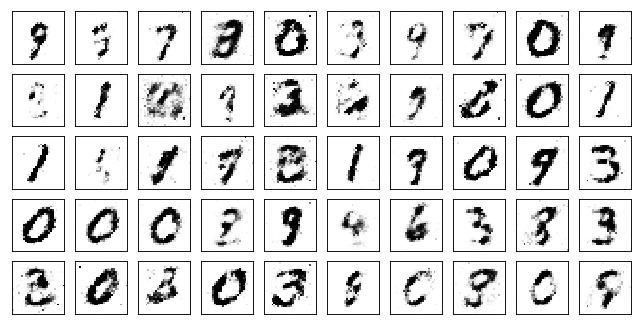

Test losses. G: 2.5542, D: 0.1560
Train Epoch: 26 [0/50000 (0%)]	Losses G: 2.9794, D: 0.2533
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 3.2001, D: 0.2279
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 2.7500, D: 0.2370


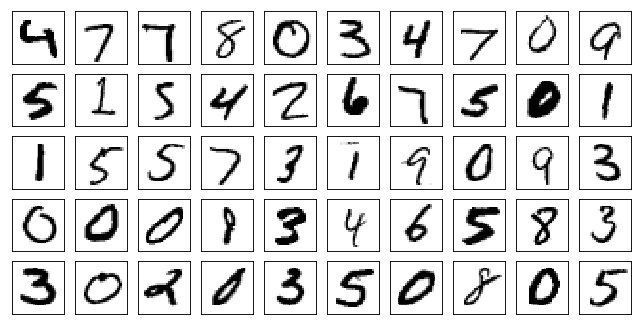

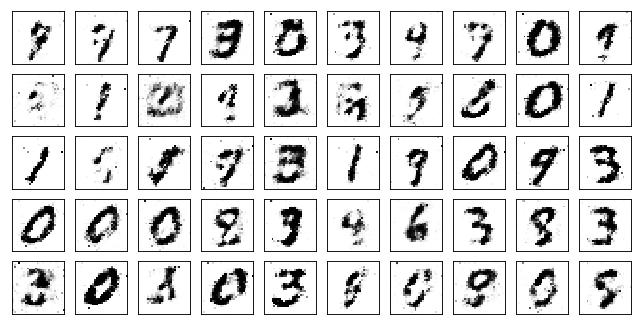

Test losses. G: 2.6087, D: 0.1421
Train Epoch: 27 [0/50000 (0%)]	Losses G: 2.5718, D: 0.2338
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 2.7338, D: 0.2563
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 1.7733, D: 0.3405


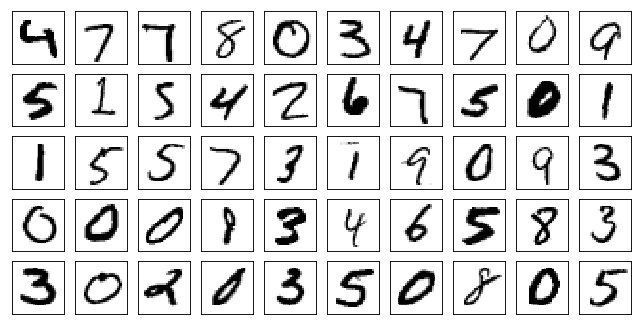

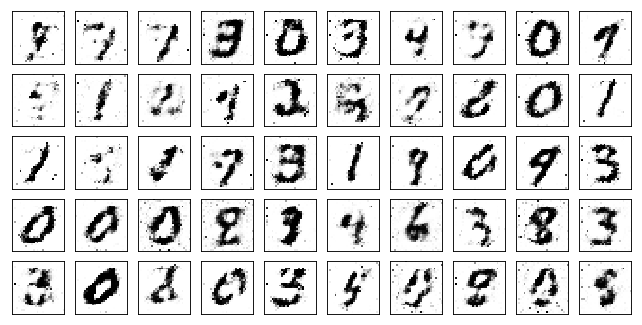

Test losses. G: 1.8622, D: 0.2313
Train Epoch: 28 [0/50000 (0%)]	Losses G: 2.0908, D: 0.3046
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 3.0853, D: 0.2418
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 3.0711, D: 0.1830


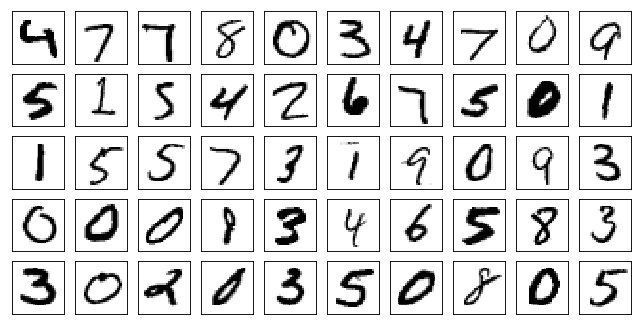

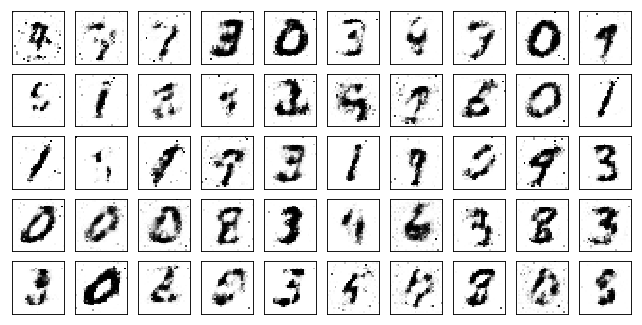

Test losses. G: 2.8389, D: 0.1051
Train Epoch: 29 [0/50000 (0%)]	Losses G: 3.2615, D: 0.2315
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 2.1185, D: 0.2965
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 2.9469, D: 0.2726


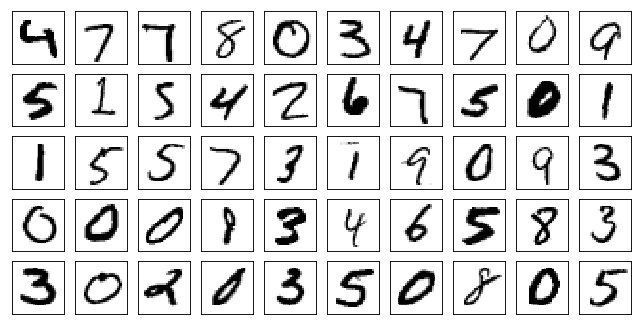

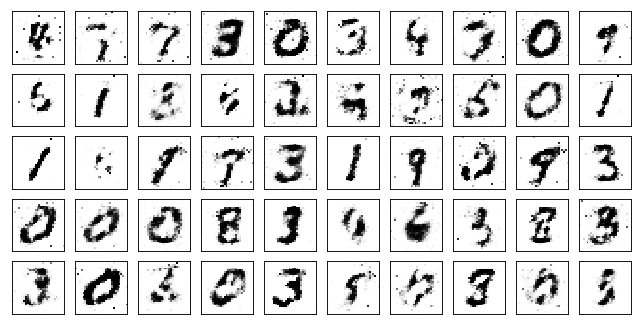

Test losses. G: 2.8668, D: 0.1896
Train Epoch: 30 [0/50000 (0%)]	Losses G: 3.0749, D: 0.3013
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 3.6225, D: 0.2113
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 3.3094, D: 0.2082


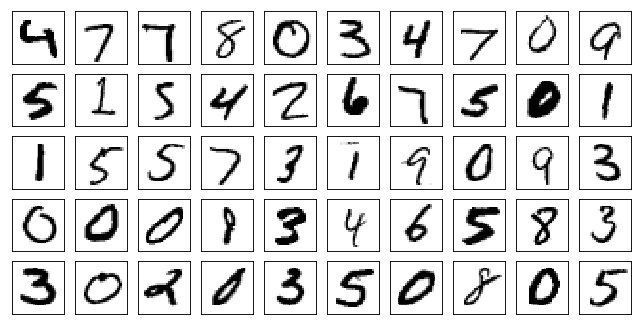

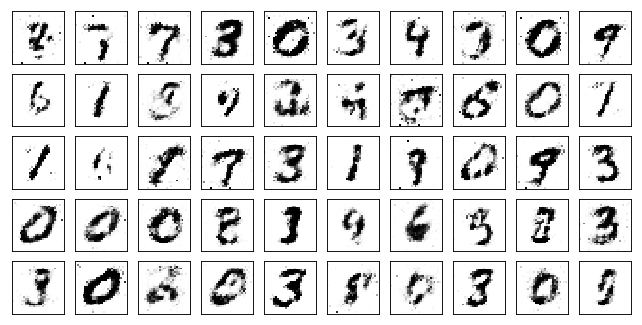

Test losses. G: 3.1226, D: 0.1416
Train Epoch: 31 [0/50000 (0%)]	Losses G: 3.1474, D: 0.2321
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 3.0900, D: 0.3198
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 2.7538, D: 0.2629


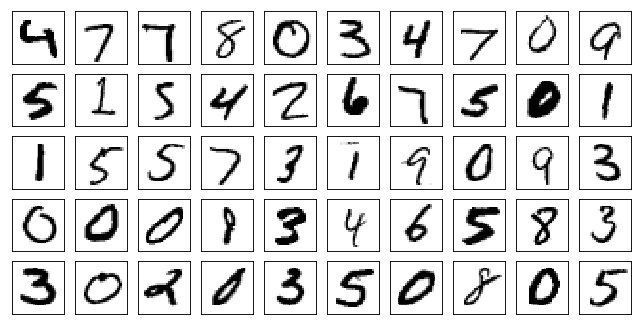

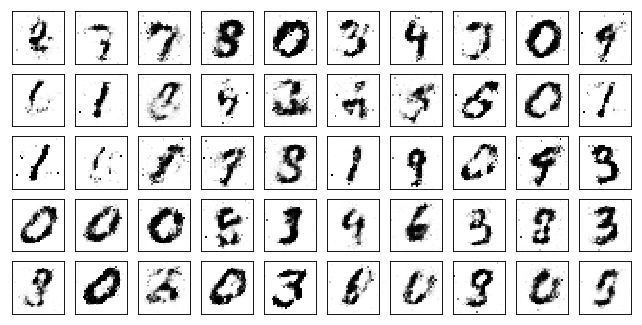

Test losses. G: 2.6978, D: 0.1668
Train Epoch: 32 [0/50000 (0%)]	Losses G: 3.3531, D: 0.2229
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 3.2382, D: 0.2636
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 2.4185, D: 0.2605


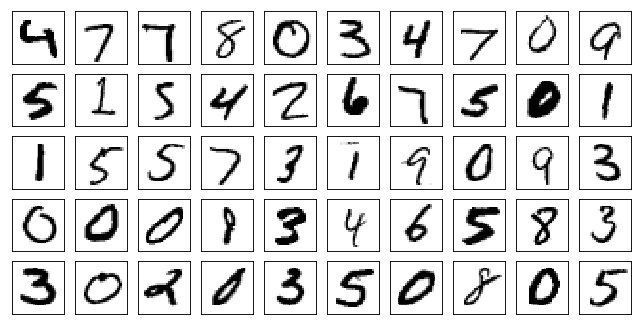

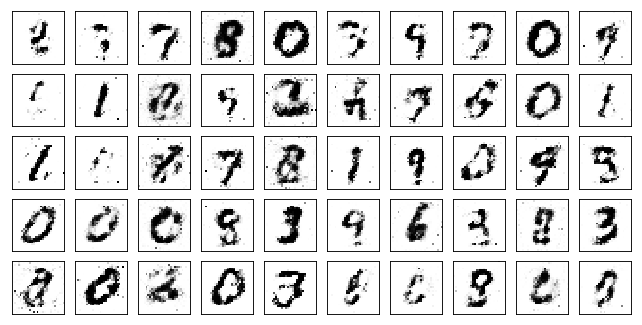

Test losses. G: 2.4208, D: 0.1622
Train Epoch: 33 [0/50000 (0%)]	Losses G: 3.0034, D: 0.2450
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 3.1177, D: 0.2095
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 3.3901, D: 0.2593


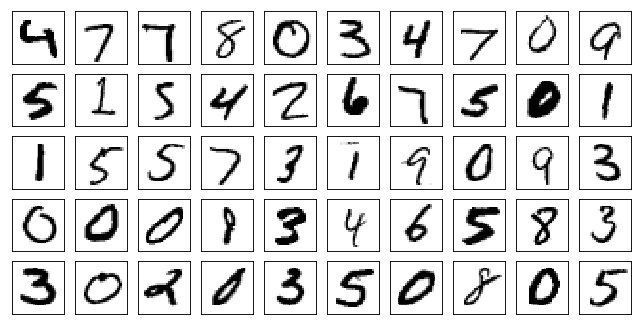

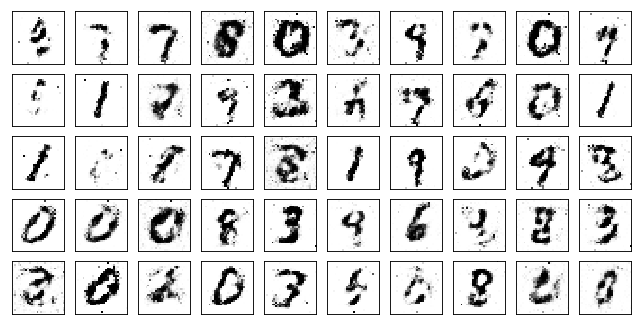

Test losses. G: 3.2170, D: 0.1863
Train Epoch: 34 [0/50000 (0%)]	Losses G: 2.8232, D: 0.2724
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 2.7948, D: 0.2758
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 3.2276, D: 0.2416


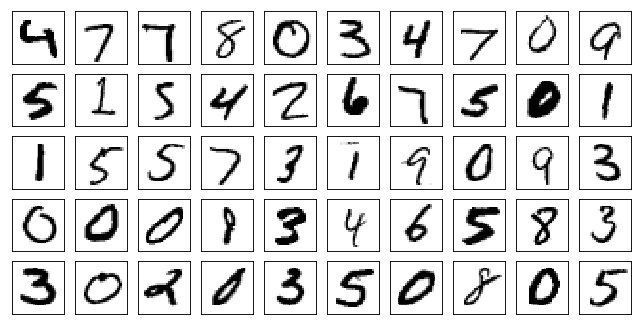

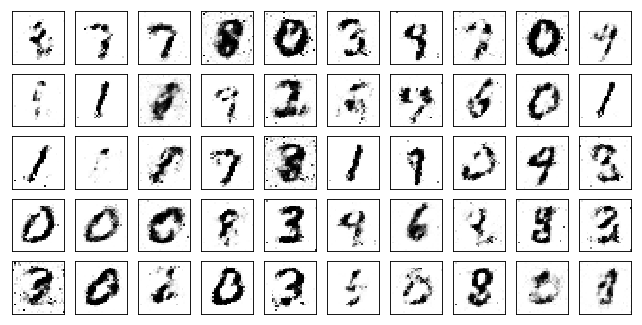

Test losses. G: 2.8603, D: 0.1950
Train Epoch: 35 [0/50000 (0%)]	Losses G: 2.7104, D: 0.3276
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 2.8841, D: 0.2752
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 2.9142, D: 0.2423


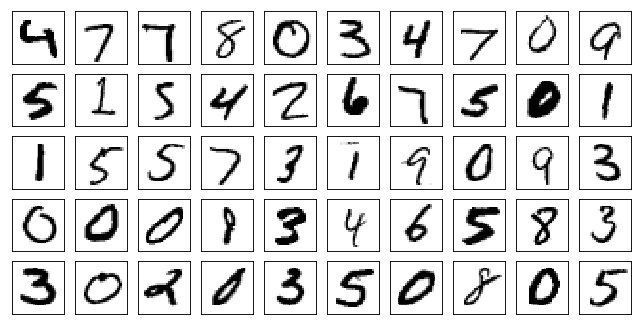

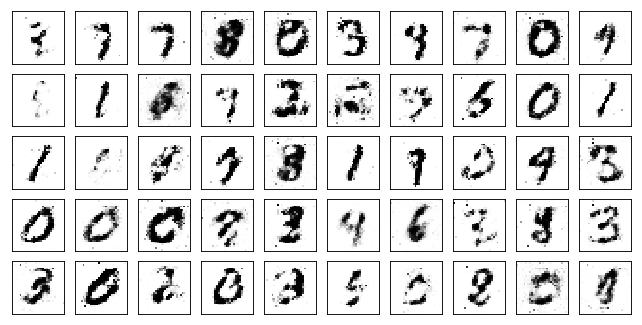

Test losses. G: 2.8090, D: 0.1591
Train Epoch: 36 [0/50000 (0%)]	Losses G: 2.9036, D: 0.2122
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 2.5912, D: 0.2732
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 2.7933, D: 0.2727


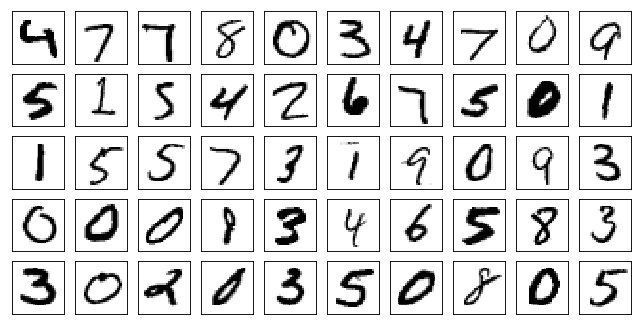

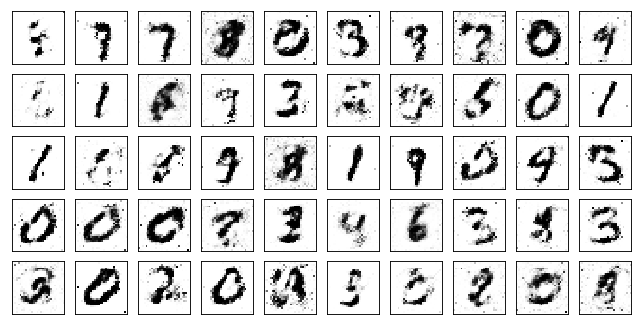

Test losses. G: 2.4156, D: 0.1803
Train Epoch: 37 [0/50000 (0%)]	Losses G: 2.9597, D: 0.2246
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 2.1031, D: 0.2172
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 2.6379, D: 0.2879


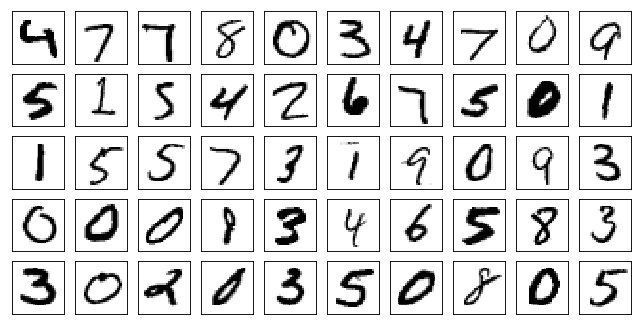

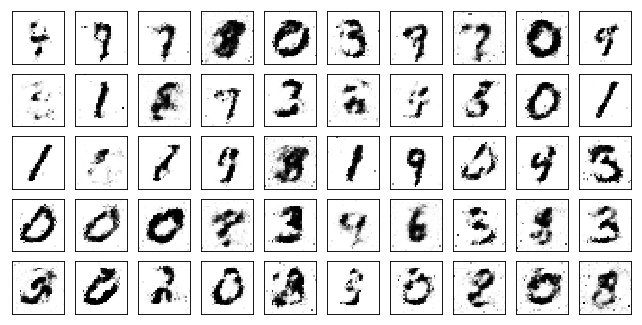

Test losses. G: 2.4264, D: 0.1697
Train Epoch: 38 [0/50000 (0%)]	Losses G: 2.7664, D: 0.2759
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 2.4474, D: 0.3516
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 2.5898, D: 0.3623


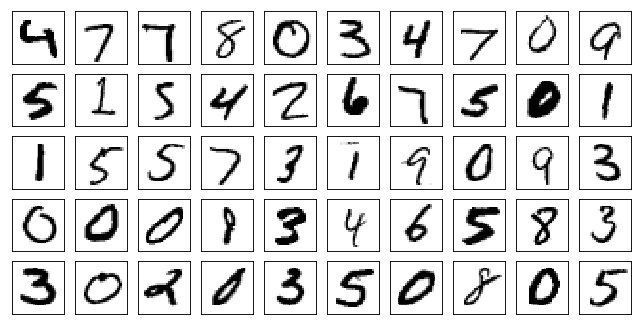

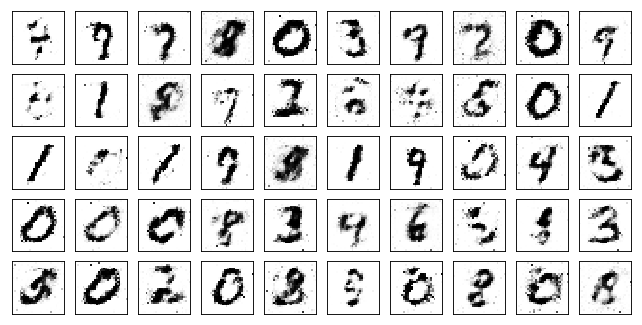

Test losses. G: 2.4578, D: 0.2347
Train Epoch: 39 [0/50000 (0%)]	Losses G: 2.9996, D: 0.3108
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 2.8083, D: 0.3708
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.9317, D: 0.2821


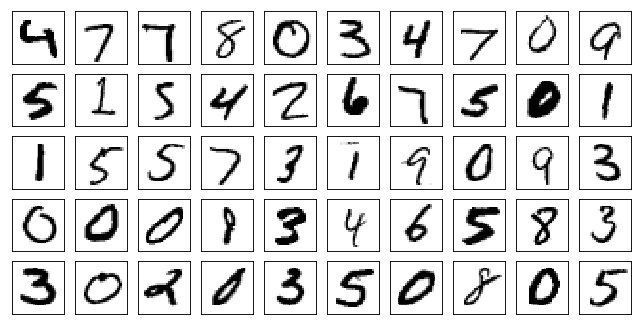

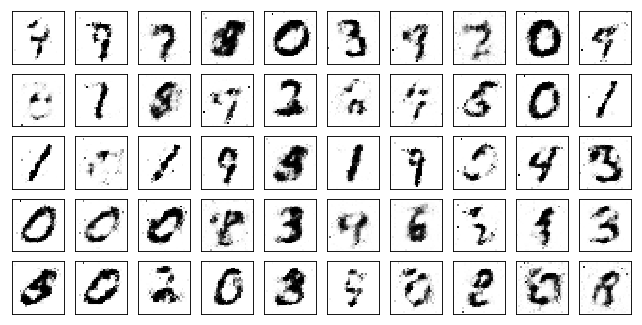

Test losses. G: 1.7716, D: 0.2159
Train Epoch: 40 [0/50000 (0%)]	Losses G: 2.4315, D: 0.3294
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 2.6745, D: 0.2677
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 2.4644, D: 0.2890


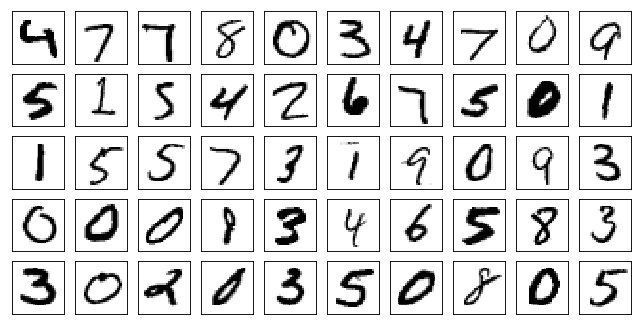

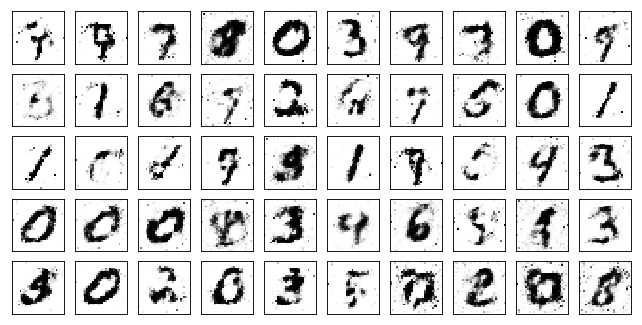

Test losses. G: 2.4781, D: 0.2126
Train Epoch: 41 [0/50000 (0%)]	Losses G: 2.2849, D: 0.2629
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 2.1800, D: 0.3183
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 2.6489, D: 0.3661


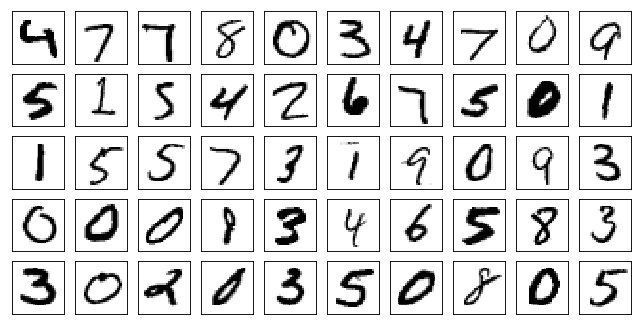

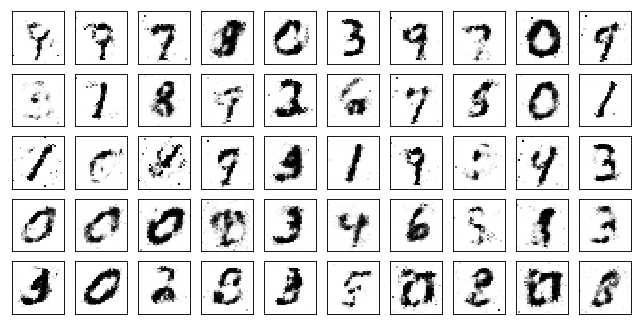

Test losses. G: 2.6921, D: 0.2205
Train Epoch: 42 [0/50000 (0%)]	Losses G: 2.1889, D: 0.3260
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 2.2983, D: 0.3520
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 2.2450, D: 0.3453


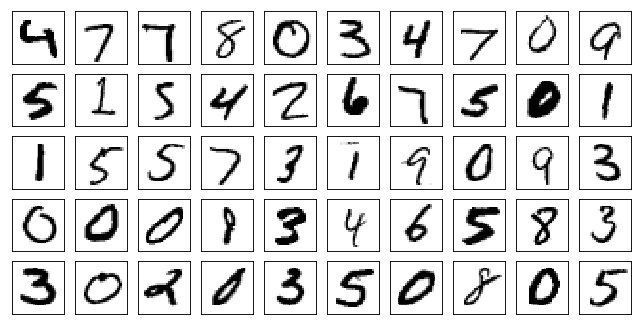

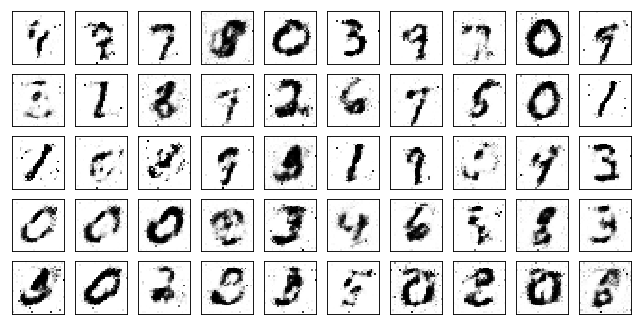

Test losses. G: 2.2397, D: 0.2174
Train Epoch: 43 [0/50000 (0%)]	Losses G: 1.9284, D: 0.2789
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 2.3376, D: 0.2875
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 2.3201, D: 0.3741


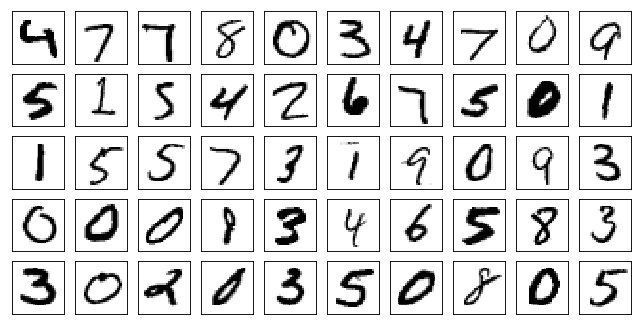

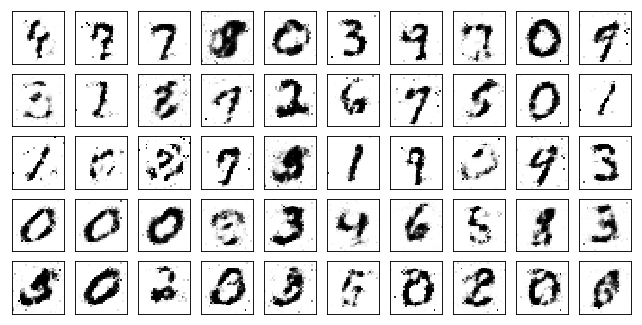

Test losses. G: 2.2140, D: 0.2464
Train Epoch: 44 [0/50000 (0%)]	Losses G: 1.9689, D: 0.3774
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 2.2346, D: 0.2890
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 2.4755, D: 0.2699


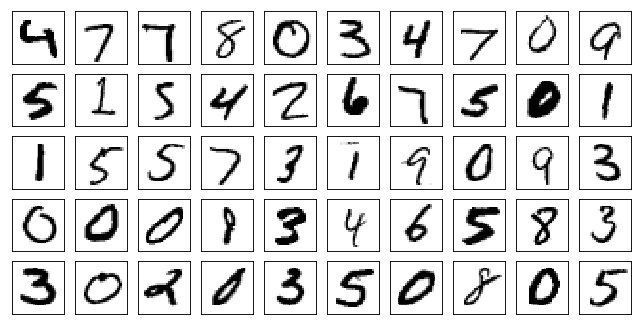

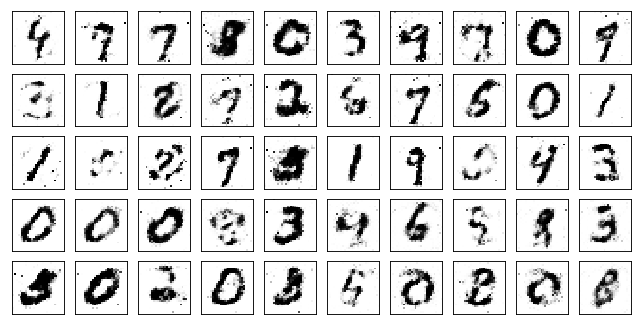

Test losses. G: 2.4155, D: 0.1786
Train Epoch: 45 [0/50000 (0%)]	Losses G: 2.3468, D: 0.2626
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 2.8348, D: 0.2763
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 2.5958, D: 0.3056


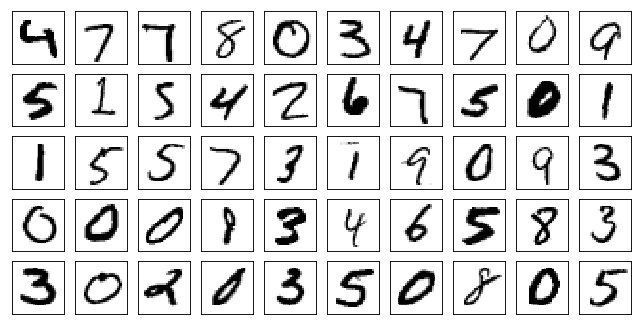

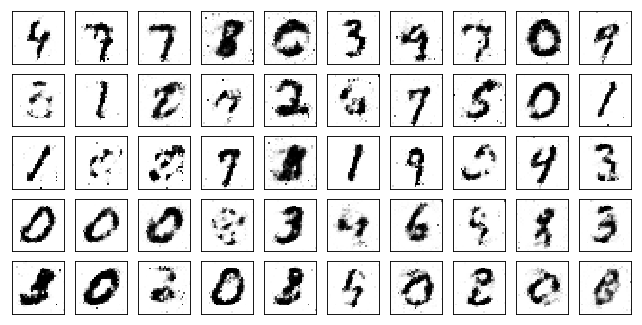

Test losses. G: 2.3332, D: 0.2041
Train Epoch: 46 [0/50000 (0%)]	Losses G: 2.5393, D: 0.2780
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 1.8530, D: 0.3242
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 1.9940, D: 0.3538


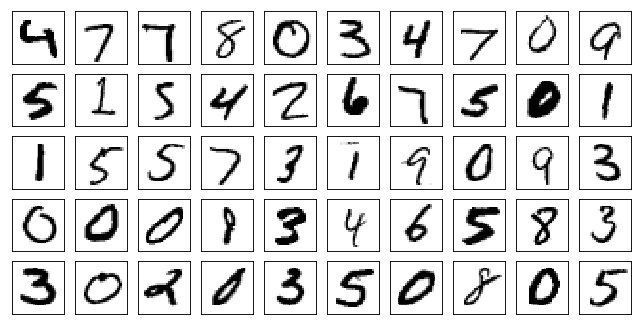

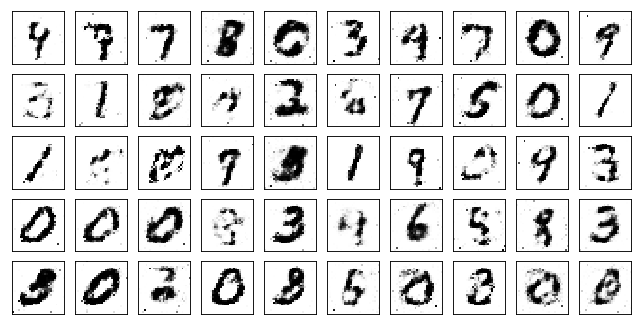

Test losses. G: 1.8453, D: 0.2553
Train Epoch: 47 [0/50000 (0%)]	Losses G: 1.7991, D: 0.3373
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 2.3512, D: 0.3132
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 2.8982, D: 0.2713


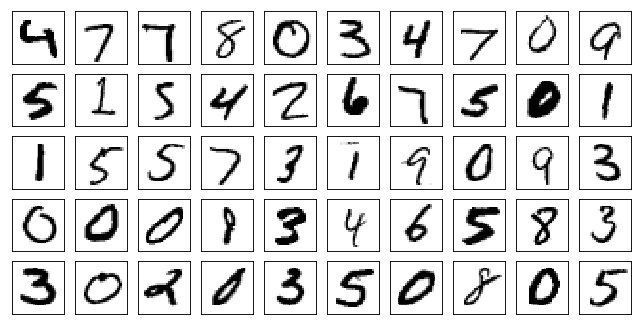

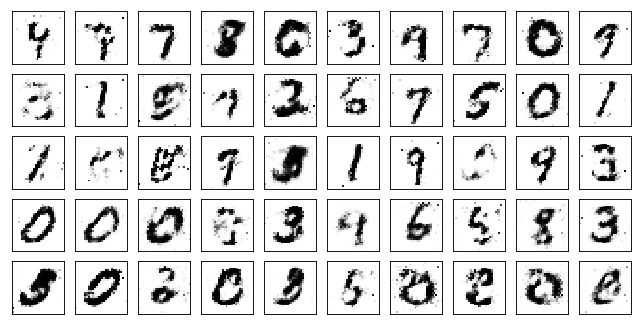

Test losses. G: 2.7191, D: 0.1841
Train Epoch: 48 [0/50000 (0%)]	Losses G: 3.2630, D: 0.2338
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 1.7154, D: 0.3904
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 2.0444, D: 0.4486


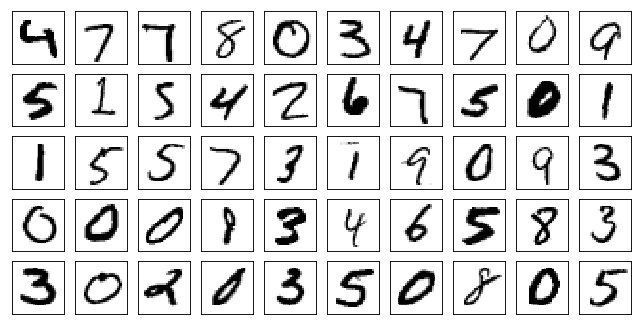

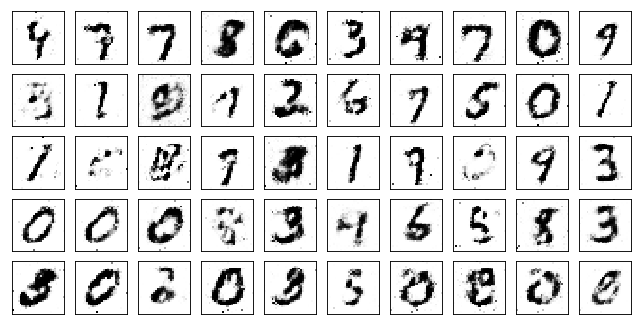

Test losses. G: 1.8976, D: 0.3118
Train Epoch: 49 [0/50000 (0%)]	Losses G: 2.2545, D: 0.3852
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 2.1629, D: 0.3457
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 1.9368, D: 0.2940


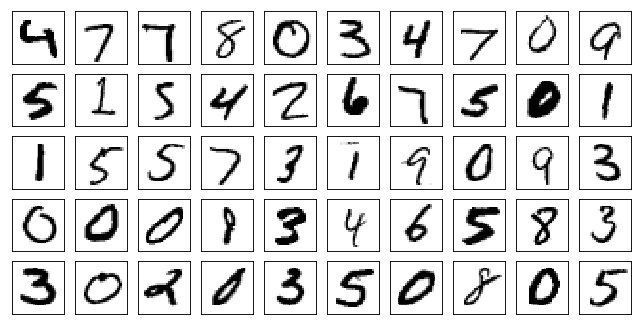

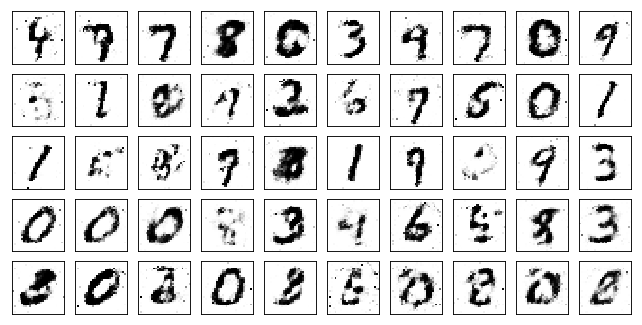

Test losses. G: 1.9742, D: 0.2282
Train Epoch: 50 [0/50000 (0%)]	Losses G: 2.3797, D: 0.3185
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 2.4068, D: 0.3310
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 2.1777, D: 0.3407


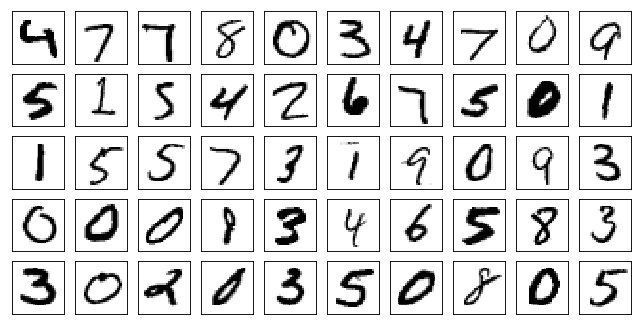

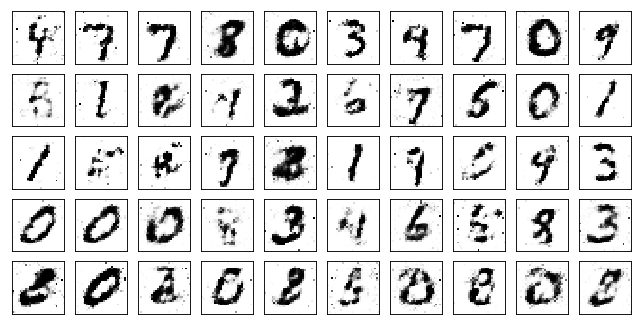

Test losses. G: 2.0593, D: 0.2380


In [12]:
with torch.cuda.device(0):
    for epoch in range(1, 51):
        G.train()
        D.train()
        train(epoch, G, D, train_log)
        G.eval()
        D.eval()
        test(G, D, valid_loader, epoch, test_log)

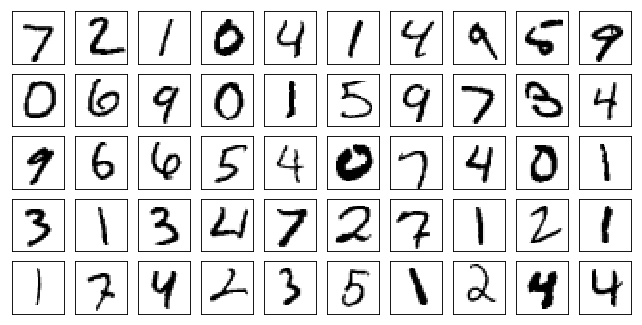

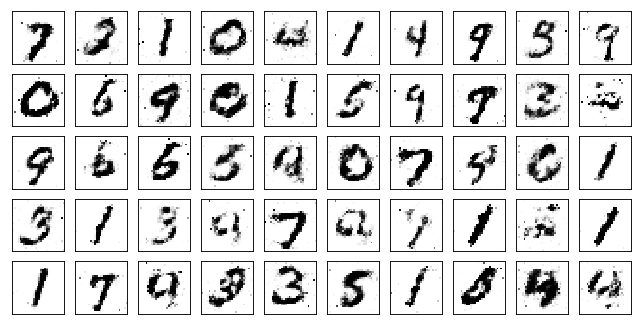

In [14]:
# testing conditional generation

_, _, test_loader = mnist(batch_size=50, valid=10000, transform=mnist_tanh)
test_data, labels = next(iter(test_loader))
    
test_z = torch.randn((50, 100))
test_y = torch.eye(10)[labels]

test_gen = G(torch.cat((test_z, test_y), 1)).data.numpy().reshape(50, 1, 28, 28)
plot_mnist(test_data, (5, 10))
plot_mnist(test_gen, (5, 10))